# Spotify: predict popularity based on lyrics and audio features

In [1]:
#Libraries to import
import pandas as pd
import numpy as np
from googletrans import Translator
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import pipeline, AutoTokenizer
from nltk.probability import FreqDist
from gensim.models import LdaModel
from gensim import corpora
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
import math
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score

### 1. Data Pre-Processing

#### 1.1 Cleaning Data
- Missing values: 260 songs doesnt contain lyrics, remove from the dataset
- Duplicates: different version of the same songs, keep only the ones with higher popularity scores
- Language: Only english and spanish songs will be used (account for 99% of the dataset)
- Year release: relevant data from 1990 onwards (previous years are highly irrelevant in numbers)

In [ ]:
###1. DATA PRE-PROCESSING
df = pd.read_csv("spotify_songs.csv")
pd.set_option('display.max_rows', None)

#1.1 Cleaning Data

#Missing values: 260 songs dont contain lyrics
print("Missing values per variable:")
print(df.isnull().sum())
df.dropna(subset=["lyrics"], inplace=True)

#Check duplicates:
    #Lyrics duplicates: Remove duplicates by keeping only the row with the highest "track_popularity"
duplicates = df[df.duplicated(subset=['lyrics'],keep=False)]
df = df.loc[df.groupby('lyrics')['track_popularity'].idxmax()]
    #Track name and artist duplicates: Remove duplicates by keeping only the row with the highest "track_popularity"
duplicates = df[df.duplicated(subset=['track_name', 'track_artist'], keep=False)]
df = df.loc[df.groupby(['track_name', 'track_artist'])['track_popularity'].idxmax()]

#Language: Only english and spanish songs will be used (both more representatives)
print("Number of songs per language:")
print(pd.crosstab(index = df['language'], columns = 'counts'))
languages=['en','es']
df=df[df['language'].isin(languages) ]

#Year release: relevant data from 1990 onwards
df['year'] = df['track_album_release_date'].str[:4]
df['year'] = pd.to_numeric(df['year'], errors='coerce')
print("Number of songs per year")
print(pd.crosstab(index = df['year'], columns = 'counts'))
df = df[df['year'] >= 1990]

#Drop irrelevant variables
df = df.drop(columns=['track_id','track_album_id','track_album_release_date',
                      'track_album_name','playlist_name','playlist_id','key','mode','track_name',
                      'valence','tempo'], axis=1)

df.reset_index(drop=True, inplace=True)

Missing values per variable:
track_id                      0
track_name                    0
track_artist                  0
lyrics                      260
track_popularity              0
track_album_id                0
track_album_name              0
track_album_release_date      0
playlist_name                 0
playlist_id                   0
playlist_genre                0
playlist_subgenre             0
danceability                  0
energy                        0
key                           0
loudness                      0
mode                          0
speechiness                   0
acousticness                  0
instrumentalness              0
liveness                      0
valence                       0
tempo                         0
duration_ms                   0
language                    260
dtype: int64
Number of songs per language:
col_0     counts
language        
af             5
ar             2
ca             2
cs             2
cy            11
da       

#### 1.2 Cleaning Text Variables
- Translate spanish songs to english (those without traslation available will be removed)
- Stopwords, text cleaning, punctuation, lemmatization: Reduce the nuances words in the lyrics

In [ ]:
# 1.2 Cleaning Text variables

# Reset the DataFrame index
df.index = np.arange(0, len(df))

# Initialize the translator
translator = Translator()

# Add a new column for translated lyrics
df['lyrics_traslated'] = ''

# Translate song lyrics
for i in range(len(df)):
    if df.loc[i, 'language'] == 'es':  
        text = df.loc[i, 'lyrics']
        try:
            translated_text = translator.translate(text, dest='en').text
            df.loc[i, 'lyrics_traslated'] = translated_text  
        except TypeError:
            df.loc[i, 'lyrics_traslated'] = 'No translation available'  
    else:
        df.loc[i, 'lyrics_traslated'] = df.loc[i, 'lyrics']  

# Count songs without translations
n_song = (df['lyrics_traslated'] == 'No translation available').sum()
print(f"Number of songs without translation: {n_song}")

# Remove rows where translation is not available (145 songs)
df = df[df['lyrics_traslated'] != 'No translation available']



Number of songs without translation: 145


In [ ]:
#Stopwords, text cleaning, punctuation and lemmatization

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

    #New stopwords:
new_stopwords=["know","cause","boom","n't", "yeah", "got","oh​","let","keep","ohh","oooh",
               "gon","back","make","one","way", "ooh","oh", "come","way","'ve" ,"'re" ,
               "wan","'ll", "'em", "put","tell", "hey", "every", "say", "still","want",
               "ayy", ",", "'",":", "/", "NA"]

    # Combine default stopwords with custom stopwords
stop_words = set(stopwords.words('english')).union(new_stopwords)

    #Function to clean the text
def cleaning_text(data):

         #Stopword in english (need to add more words)
    stop_words = stopwords.words('english') + new_stopwords

    # Text cleaning
    data = re.sub(r'[^\w\s]', '', data).lower()

    # Tokenization
    tokens=word_tokenize(data)

    # Initialize lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Lemmatize tokens and filter out stopwords
    cleaned_tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens if word not in stop_words and len(word) > 2
    ]


    return ' '.join(cleaned_tokens)

df['clean_lyrics'] = df['lyrics_traslated'].apply(cleaning_text)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


#### 1.3 Text variable: Sentiment and Emotions
- Vader lexicon: analyze simple sentiment of songs (positive, negative, neutral)
- Emotion classifier: analyze deeper emotions (anger, surprise, joy, neutral, sadness, fear, disgust)

In [ ]:
#1.3.1 Sentiment Analysis : VADER LEXICON

# Ensure VADER lexicon is downloaded
nltk.download('vader_lexicon')
# Initialize the Sentiment Intensity Analyzer
sid = SentimentIntensityAnalyzer()

def analyze_sentiment(data):
    """
    Analyzes sentiment using VADER SentimentIntensityAnalyzer.
    Returns DataFrame columns for positive, negative, neutral, and compound scores.
    """
    sentiment_scores = data.apply(lambda x: sid.polarity_scores(x) if isinstance(x, str) and pd.notnull(x) else None)

    # Extract scores into separate lists
    positive = sentiment_scores.apply(lambda x: x['pos'] if x else np.nan)
    negative = sentiment_scores.apply(lambda x: x['neg'] if x else np.nan)
    neutral = sentiment_scores.apply(lambda x: x['neu'] if x else np.nan)
    compound = sentiment_scores.apply(lambda x: x['compound'] if x else np.nan)

    return positive, negative, neutral, compound

df["positive"], df["negative"],df["neutral"], df["compound"] = analyze_sentiment(df["clean_lyrics"])
# Filter out rows with missing sentiment scores
df = df.dropna(subset=['negative'])
# Assign sentiment labels based on the compound score
df["sentiment"] = df["compound"].apply(
    lambda x: 'Positive' if x >= 0.5 else 'Negative' if x <= -0.5 else 'Neutral'
)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
#1.3.2 Emotion Analysis :Emotion English DistilRoBERTa-base

# Initialize the tokenizer and emotion classification pipeline
model_name = "j-hartmann/emotion-english-distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
emotion_classifier = pipeline(
    "text-classification",
    model=model_name,
    top_k=None
)

# Function for emotion analysis
def emotion_analysis(data):
    """
    Performs emotion analysis on the input text data using a pre-trained model.
    Returns scores for each emotion as DataFrame columns.
    """
    emotions = ['anger', 'surprise', 'joy', 'neutral', 'sadness', 'fear', 'disgust']
    emotion_scores = {emotion: [] for emotion in emotions}

    for text in data:
        try:

            # Use AutoTokenizer to truncate the text
            tokenized = tokenizer(
                text,
                truncation=True,
                max_length=512,
                return_tensors="pt"
            )
            truncated_text = tokenizer.decode(tokenized['input_ids'][0], skip_special_tokens=True)

            # Perform emotion classification
            results = emotion_classifier(truncated_text)

            # Reset temporary score dictionary for the current text
            temp_scores = {emotion: 0.0 for emotion in emotions}

            # Assign scores based on keys in the results
            for res in results[0]:  # Iterate over model output
                temp_scores[res['label']] = res['score']  # Match score to the correct emotion

            # Append scores to emotion_scores dictionary
            for emotion in emotions:
                emotion_scores[emotion].append(temp_scores[emotion])
        except Exception as e:
            # Handle any exceptions by appending NaN
            for emotion in emotions:
                emotion_scores[emotion].append(np.nan)


    return pd.DataFrame(emotion_scores)

# Apply emotion analysis and merge with the original DataFrame
emotion_scores_df = emotion_analysis(df["clean_lyrics"])

# List of emotion columns
emotions = ['anger', 'surprise', 'joy', 'neutral_emotion', 'sadness', 'fear', 'disgust']
# Rename columns to match the emotions list
emotion_scores_df.columns = emotions

df = pd.concat([df, emotion_scores_df], axis=1)
# Filter rows with NaN values in the 'anger' column
df = df.dropna(subset=['anger'])

# Determine the strongest emotion for each row
df['strongest_emotion'] = df[emotions].idxmax(axis=1)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

Device set to use cpu


#### 1.4 Text variable: Lexical diversity
- Measure the ratio of unique wors to total words that songs use

In [44]:
#1.4 Lexical diversity

def calculate_lexical_diversity(text):
    """
    Calculate lexical diversity for a given text.
    Lexical Diversity = Number of Unique Words / Total Number of Words
    """
    # Ensure the input is a string
    if isinstance(text, float):
        text = str(text)  # Convert float to string if necessary

    # Tokenize the text
    tokens = word_tokenize(text)

    # Calculate unique words and total words
    unique_words = len(set(tokens))
    total_words = len(tokens)

    # Avoid division by zero
    return unique_words / total_words if total_words > 0 else 0

# Apply lexical diversity calculation to the 'clean_lyrics' column
df['lexical_diversity'] = df['clean_lyrics'].apply(calculate_lexical_diversity)


#### 1.5 Text variable: Topics with LDA for each genre
- 1. First determinate the number of topics per genre


Evaluating genre: rap


C:\Users\gpnc_\AppData\Local\Temp\ipykernel_21432\3803744528.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre_df['clean_lyrics'] = genre_df['clean_lyrics'].fillna("").astype(str)


  Number of Topics: 2 | Coherence Score: 0.3164
  Number of Topics: 3 | Coherence Score: 0.2917
  Number of Topics: 4 | Coherence Score: 0.3074
  Number of Topics: 5 | Coherence Score: 0.2981
  Number of Topics: 6 | Coherence Score: 0.3008

Evaluating genre: rock


C:\Users\gpnc_\AppData\Local\Temp\ipykernel_21432\3803744528.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre_df['clean_lyrics'] = genre_df['clean_lyrics'].fillna("").astype(str)


  Number of Topics: 2 | Coherence Score: 0.3585
  Number of Topics: 3 | Coherence Score: 0.3655
  Number of Topics: 4 | Coherence Score: 0.3521
  Number of Topics: 5 | Coherence Score: 0.3581
  Number of Topics: 6 | Coherence Score: 0.3468

Evaluating genre: pop


C:\Users\gpnc_\AppData\Local\Temp\ipykernel_21432\3803744528.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre_df['clean_lyrics'] = genre_df['clean_lyrics'].fillna("").astype(str)


  Number of Topics: 2 | Coherence Score: 0.3945
  Number of Topics: 3 | Coherence Score: 0.4091
  Number of Topics: 4 | Coherence Score: 0.4005
  Number of Topics: 5 | Coherence Score: 0.3892
  Number of Topics: 6 | Coherence Score: 0.3671

Evaluating genre: r&b


C:\Users\gpnc_\AppData\Local\Temp\ipykernel_21432\3803744528.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre_df['clean_lyrics'] = genre_df['clean_lyrics'].fillna("").astype(str)


  Number of Topics: 2 | Coherence Score: 0.3554
  Number of Topics: 3 | Coherence Score: 0.3487
  Number of Topics: 4 | Coherence Score: 0.3609
  Number of Topics: 5 | Coherence Score: 0.3634
  Number of Topics: 6 | Coherence Score: 0.3477

Evaluating genre: edm


C:\Users\gpnc_\AppData\Local\Temp\ipykernel_21432\3803744528.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre_df['clean_lyrics'] = genre_df['clean_lyrics'].fillna("").astype(str)


  Number of Topics: 2 | Coherence Score: 0.4433
  Number of Topics: 3 | Coherence Score: 0.4349
  Number of Topics: 4 | Coherence Score: 0.4311
  Number of Topics: 5 | Coherence Score: 0.4253
  Number of Topics: 6 | Coherence Score: 0.4218

Evaluating genre: latin


C:\Users\gpnc_\AppData\Local\Temp\ipykernel_21432\3803744528.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre_df['clean_lyrics'] = genre_df['clean_lyrics'].fillna("").astype(str)


  Number of Topics: 2 | Coherence Score: 0.3629
  Number of Topics: 3 | Coherence Score: 0.3690
  Number of Topics: 4 | Coherence Score: 0.3296
  Number of Topics: 5 | Coherence Score: 0.3470
  Number of Topics: 6 | Coherence Score: 0.3587


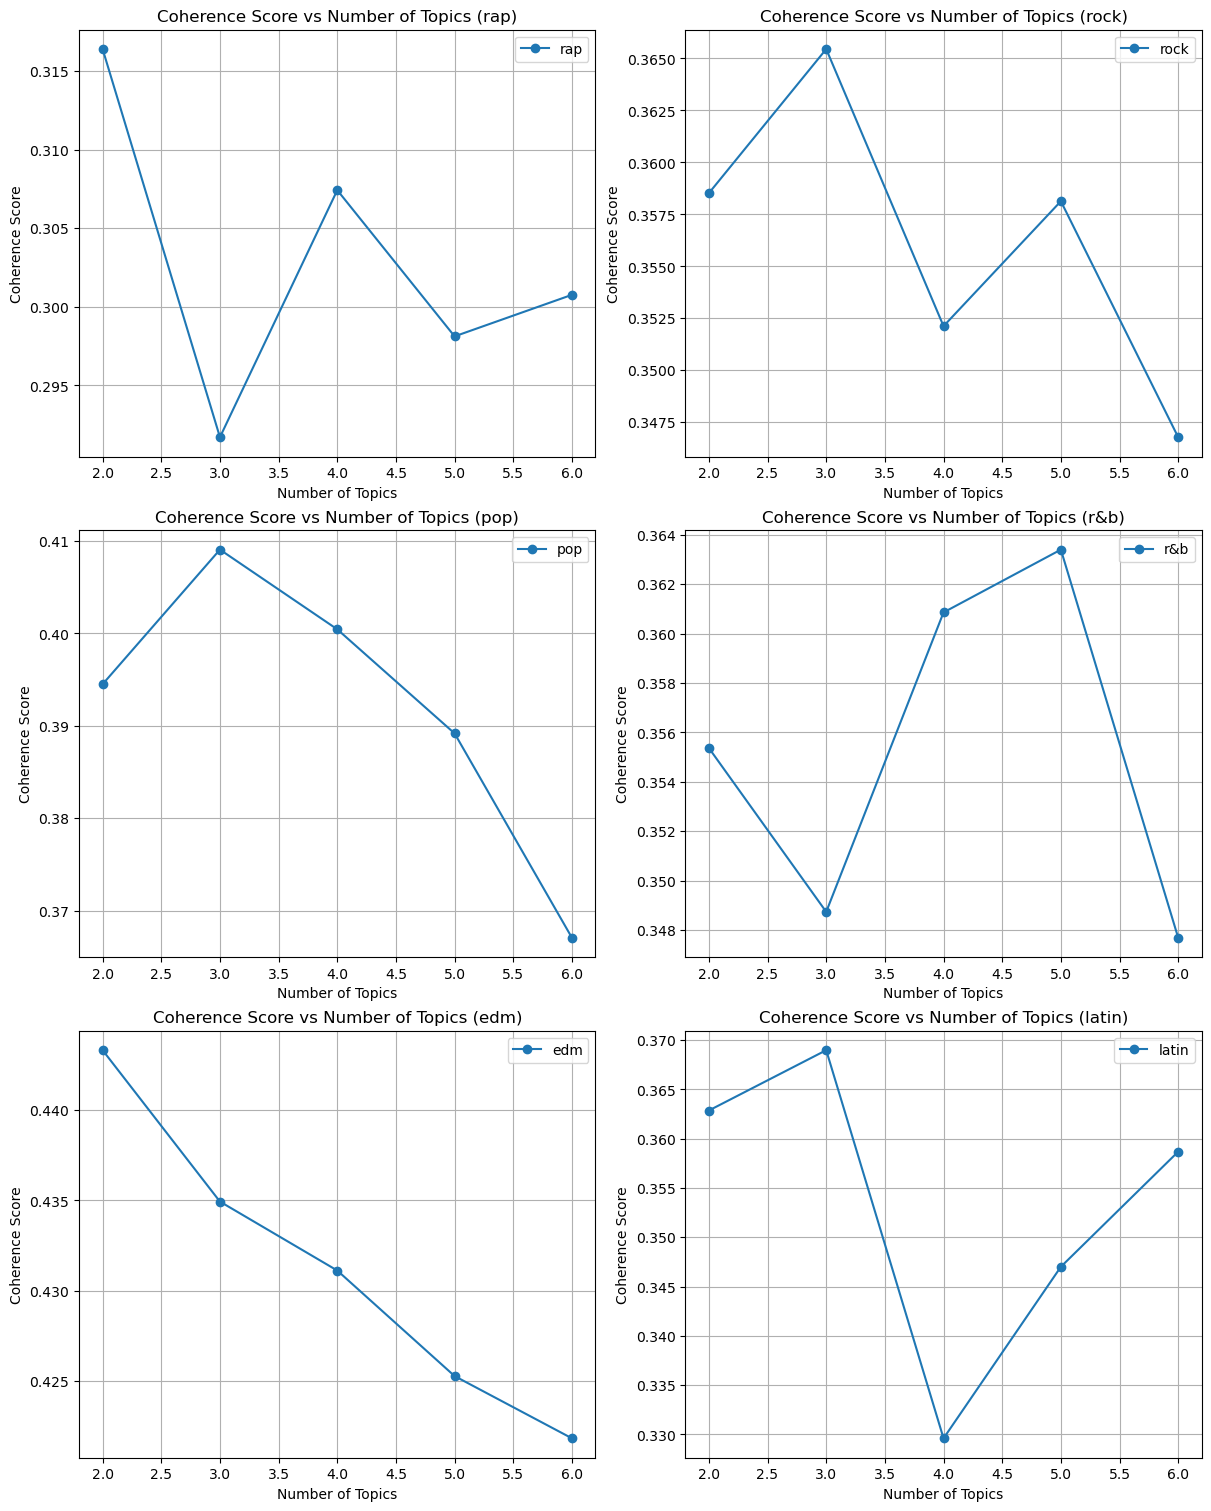

In [14]:
# 1.5.1 Evaluate the number of topics per genre in LDA

df = df.dropna(subset=['clean_lyrics'])
# Function to evaluate the coherence score for different numbers of topics by genre
def evaluate_num_topics_per_genre(df, genres, start=2, limit=6, step=1):
    """
    Evaluates coherence scores for a range of topic numbers per genre.

    Args:
        df: DataFrame containing the song lyrics and genres.
        genres: List of unique genres to process.
        start: Minimum number of topics.
        limit: Maximum number of topics.
        step: Step size for the number of topics.

    Returns:
        A dictionary with genres as keys and lists of (number of topics, coherence score) tuples as values.
    """
    results = {}

    for genre in genres:
        print(f"\nEvaluating genre: {genre}")

        # Filter DataFrame for the current genre
        genre_df = df[df['playlist_genre'] == genre]

        # Ensure all lyrics are strings and handle missing values
        genre_df['clean_lyrics'] = genre_df['clean_lyrics'].fillna("").astype(str)

        # Tokenized texts from the 'clean_lyrics' column
        tokenized_lyrics = genre_df['clean_lyrics'].apply(str.split).tolist()

        # Create dictionary and corpus
        dictionary = corpora.Dictionary(tokenized_lyrics)
        corpus = [dictionary.doc2bow(text) for text in tokenized_lyrics]

        coherence_scores = []
        topic_range = range(start, limit + 1, step)

        for num_topics in topic_range:
            # Train LDA model
            lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=5)

            # Compute coherence score
            coherence_model = CoherenceModel(model=lda, texts=tokenized_lyrics, dictionary=dictionary, coherence='c_v')
            coherence_score = coherence_model.get_coherence()
            coherence_scores.append((num_topics, coherence_score))
            print(f"  Number of Topics: {num_topics} | Coherence Score: {coherence_score:.4f}")

        # Store results for the current genre
        results[genre] = coherence_scores

    return results

# Get unique genres from the DataFrame
unique_genres = df['playlist_genre'].unique()

# Evaluate coherence scores per genre
genre_coherence_scores = evaluate_num_topics_per_genre(df, unique_genres, start=2, limit=6, step=1)

# Plot coherence scores for each genre
num_genres = len(genre_coherence_scores)

# Set up subplots: 2 plots per row
cols = 2
rows = (num_genres + 1) // cols  # Calculate the number of rows needed

fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 5), constrained_layout=True)

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot
for i, (genre, scores) in enumerate(genre_coherence_scores.items()):
    x, y = zip(*scores)
    ax = axes[i]
    ax.plot(x, y, marker='o', linestyle='-', label=genre)
    ax.set_title(f'Coherence Score vs Number of Topics ({genre})')
    ax.set_xlabel('Number of Topics')
    ax.set_ylabel('Coherence Score')
    ax.grid(True)
    ax.legend()

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Display the plots
plt.show()


#### 1.5 Text variable: Topics with LDA for each genre
- 2. Generate the topics per genre

In [47]:
# 1.5.2 Generate the topics per genre

df= df.dropna(subset=['clean_lyrics']) 

# Dictionary to store the number of optimal topics per genre
optimal_topics_per_genre = {
    'rap': 2,
    'rock': 3,
    'pop': 3,
    'r&b': 5,
    'edm': 2,
    'latin': 3,
}

# Dictionaries to store results
genre_results = {}  # Stores DataFrames with topic probabilities per genre
topic_words_per_genre = {}  # Stores important words and weights per topic for each genre

for genre, num_topics in optimal_topics_per_genre.items():
    print(f"Processing Genre: {genre} | Optimal Topics: {num_topics}")

    # Filter the DataFrame for the current genre
    genre_df = df[df['playlist_genre'] == genre].copy()

    # Tokenize lyrics (if not already tokenized)
    genre_df['tokenized_lyrics'] = genre_df['clean_lyrics'].apply(str.split)

    # Create dictionary and corpus for the genre
    dictionary = corpora.Dictionary(genre_df['tokenized_lyrics'])
    corpus = [dictionary.doc2bow(text) for text in genre_df['tokenized_lyrics']]

    # Train the LDA model
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=5)

    # Assign topics based on probabilities
    genre_df['Topic'] = "Mix topic"  # Default value if no topic probability > 0.6

    for i, song_bow in enumerate(corpus):
        topic_probs = lda.get_document_topics(song_bow)

        # Check if any topic probability is greater than 0.6
        max_topic, max_prob = max(topic_probs, key=lambda x: x[1], default=(None, 0.0))
        if max_prob > 0.6:
            genre_df.loc[genre_df.index[i], 'Topic'] = f"Topic {max_topic + 1}"

    # Store the genre-specific results in the dictionary
    genre_results[genre] = genre_df

    # Extract important words and weights for each topic
    topic_words = {}
    for idx, topic in lda.print_topics(num_topics=num_topics, num_words=20):
        words_and_weights = [
            f"{word.split('*')[1].strip().strip('\"')}({float(word.split('*')[0]):.2f})"
            for word in topic.split(" + ")
        ]
        topic_words[f"Topic {idx + 1}"] = ", ".join(words_and_weights)  # Combine words and weights as a string

    # Store the topic words for the current genre
    topic_words_per_genre[genre] = topic_words

# Create a unified DataFrame with the important words and weights for all genres
rows = []
for genre, topics in topic_words_per_genre.items():
    for topic, words_and_weights in topics.items():
        rows.append({"Genre": genre, "Topic": topic, "Words": words_and_weights})

# Create a DataFrame from the rows
topics_df = pd.DataFrame(rows, columns=["Genre", "Topic", "Words"])

# Display the unified DataFrame
pd.set_option('display.max_colwidth', None)
display(topics_df)
pd.set_option('display.max_colwidth', 50)

# Merge topic assignments back into the original DataFrame
df = pd.concat(genre_results.values(), ignore_index=True)


Processing Genre: rap | Optimal Topics: 2
Processing Genre: rock | Optimal Topics: 3
Processing Genre: pop | Optimal Topics: 3
Processing Genre: r&b | Optimal Topics: 5
Processing Genre: edm | Optimal Topics: 2
Processing Genre: latin | Optimal Topics: 3


,Genre,Topic,Words
0,rap,Topic 1,"like(0.02), dont(0.01), get(0.01), love(0.01), baby(0.01), see(0.01), time(0.01), girl(0.01), never(0.01), take(0.01), aint(0.01), youre(0.01), right(0.01), feel(0.01), man(0.00), give(0.00), cant(0.00), thats(0.00), life(0.00), need(0.00)"
1,rap,Topic 2,"nigga(0.03), like(0.02), bitch(0.01), get(0.01), aint(0.01), dont(0.01), shit(0.01), fuck(0.01), thats(0.01), money(0.01), see(0.01), cant(0.00), never(0.00), hit(0.00), as(0.00), man(0.00), big(0.00), time(0.00), bout(0.00), boy(0.00)"
2,rock,Topic 1,"never(0.01), away(0.01), dont(0.01), love(0.01), get(0.01), take(0.01), youre(0.01), time(0.01), ill(0.01), like(0.01), cant(0.01), see(0.01), wont(0.01), well(0.01), eye(0.01), feel(0.01), there(0.01), life(0.01), ive(0.01), everything(0.00)"
3,rock,Topic 2,"dont(0.02), like(0.02), time(0.01), youre(0.01), get(0.01), never(0.01), feel(0.01), love(0.01), need(0.01), life(0.01), could(0.01), day(0.01), see(0.01), ill(0.01), cant(0.01), well(0.01), baby(0.01), look(0.01), aint(0.01), away(0.01)"
4,rock,Topic 3,"love(0.02), cant(0.02), feel(0.01), youre(0.01), dont(0.01), get(0.01), like(0.01), give(0.01), take(0.01), ive(0.01), never(0.01), heart(0.01), see(0.01), baby(0.01), time(0.01), night(0.01), always(0.01), good(0.01), dream(0.01), ill(0.01)"
5,pop,Topic 1,"never(0.01), like(0.01), love(0.01), time(0.01), ill(0.01), heart(0.01), take(0.01), dont(0.01), wont(0.01), youre(0.01), well(0.01), could(0.01), thing(0.01), home(0.01), night(0.01), life(0.01), there(0.01), world(0.01), turn(0.01), young(0.01)"
6,pop,Topic 2,"like(0.01), work(0.01), love(0.01), never(0.01), baby(0.01), see(0.01), life(0.01), dont(0.01), get(0.01), ride(0.01), ill(0.01), would(0.01), right(0.01), day(0.01), time(0.01), side(0.01), youre(0.01), give(0.01), cant(0.01), light(0.00)"
7,pop,Topic 3,"dont(0.03), love(0.03), like(0.02), youre(0.02), get(0.01), cant(0.01), feel(0.01), time(0.01), baby(0.01), need(0.01), take(0.01), night(0.01), girl(0.01), away(0.01), see(0.01), ive(0.01), right(0.01), think(0.01), give(0.01), ill(0.01)"
8,r&b,Topic 1,"like(0.03), dont(0.02), cant(0.01), time(0.01), aint(0.01), get(0.01), see(0.01), youre(0.01), feel(0.01), need(0.01), think(0.01), take(0.01), girl(0.01), right(0.01), thats(0.01), really(0.01), boy(0.01), real(0.01), thing(0.01), wont(0.00)"
9,r&b,Topic 2,"youre(0.02), dont(0.01), like(0.01), life(0.01), never(0.01), rain(0.01), get(0.01), girl(0.01), used(0.01), aint(0.01), baby(0.01), better(0.01), love(0.01), thing(0.01), ill(0.01), cant(0.01), nothing(0.01), away(0.01), thats(0.01), play(0.01)"


In [23]:
#Topics generate with LDA results and LLM
summarized_topics = {
    "rap": {
        "Topic 1": "Relationships and struggles",
        "Topic 2": "Conflicts and street life"
    },
    "rock": {
        "Topic 1": "Inner struggles and personal journey",
        "Topic 2": "Love and emotional connections",
        "Topic 3": "Romantic and nostalgic expressions"
    },
    "pop": {
        "Topic 1": "Romantic longing and relationships",
        "Topic 2": "Self-expression and feelings",
        "Topic 3": "Escapism and carefree moments"
    },
    "r&b": {
        "Topic 1": "Struggles and resilience",
        "Topic 2": "Heartbreak and emotional pain",
        "Topic 3": "Relationships and admiration",
        "Topic 4": "Love and yearning",
        "Topic 5": "Passion and romantic devotion"
    },
    "edm": {
        "Topic 1": "Love and uplifting vibes",
        "Topic 2": "Nightlife and emotional connections"
    },
    "latin": {
        "Topic 1": "Passion and romance",
        "Topic 2": "Dance and celebration",
        "Topic 3": "Emotions and connections"
    }
}

# Transform dictionary into a DataFrame
rows = []
for genre, topics in summarized_topics.items():
    for topic, description in topics.items():
        rows.append({"Genre": genre, "Topic": topic, "Description": description})

# Create the DataFrame
topics_df = pd.DataFrame(rows)

# Print the DataFrame
display(topics_df)

,Genre,Topic,Description
0,rap,Topic 1,Relationships and struggles
1,rap,Topic 2,Conflicts and street life
2,rock,Topic 1,Inner struggles and personal journey
3,rock,Topic 2,Love and emotional connections
4,rock,Topic 3,Romantic and nostalgic expressions
5,pop,Topic 1,Romantic longing and relationships
6,pop,Topic 2,Self-expression and feelings
7,pop,Topic 3,Escapism and carefree moments
8,r&b,Topic 1,Struggles and resilience
9,r&b,Topic 2,Heartbreak and emotional pain


### 2. Exploratory Analysis

#### 2.1 Target variable
- The target variable will be 1 for popular and 0 to no popular
- Review the relationship between the predictors and the target variable

In [48]:
#Target Variable
df['popular'] = df['track_popularity'].apply(lambda x: 1 if x >= 62 else 0)

#Drop irrelevant variables
df = df.drop(columns=['lyrics','track_popularity','language','lyrics_traslated',
                      'clean_lyrics','compound','tokenized_lyrics'])

#### 2.2 Categorical variables


##### Genre
- The Mosaic plot shows that the data is imbalance between popular and unpopular songs for all genres. This increments in edm genre, while pop is more balance that others. This indicates that the data will need to be balance for the final model

<Figure size 1000x600 with 0 Axes>

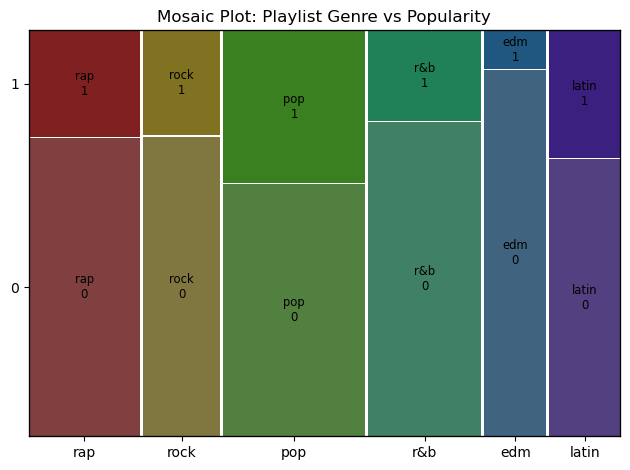

In [49]:
# Genre

#Mosaic shows the proportion for the target but also the relative proportion accross categories
# Convert 'popular' to a string for better labeling
df['popular'] = df['popular'].astype(str)

# Create the mosaic plot
plt.figure(figsize=(10, 6))
mosaic(df, ['playlist_genre', 'popular'], title='Mosaic Plot: Playlist Genre vs Popularity')
plt.ylabel('Popularity', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()


##### Sub-genre
- The same imbalance problem in genres, present in sub-genre. However in each genre, the subgenres are equally distributed. Therefore, the analysis can be amplify to sub-genre and understand different dynamics in each of them.

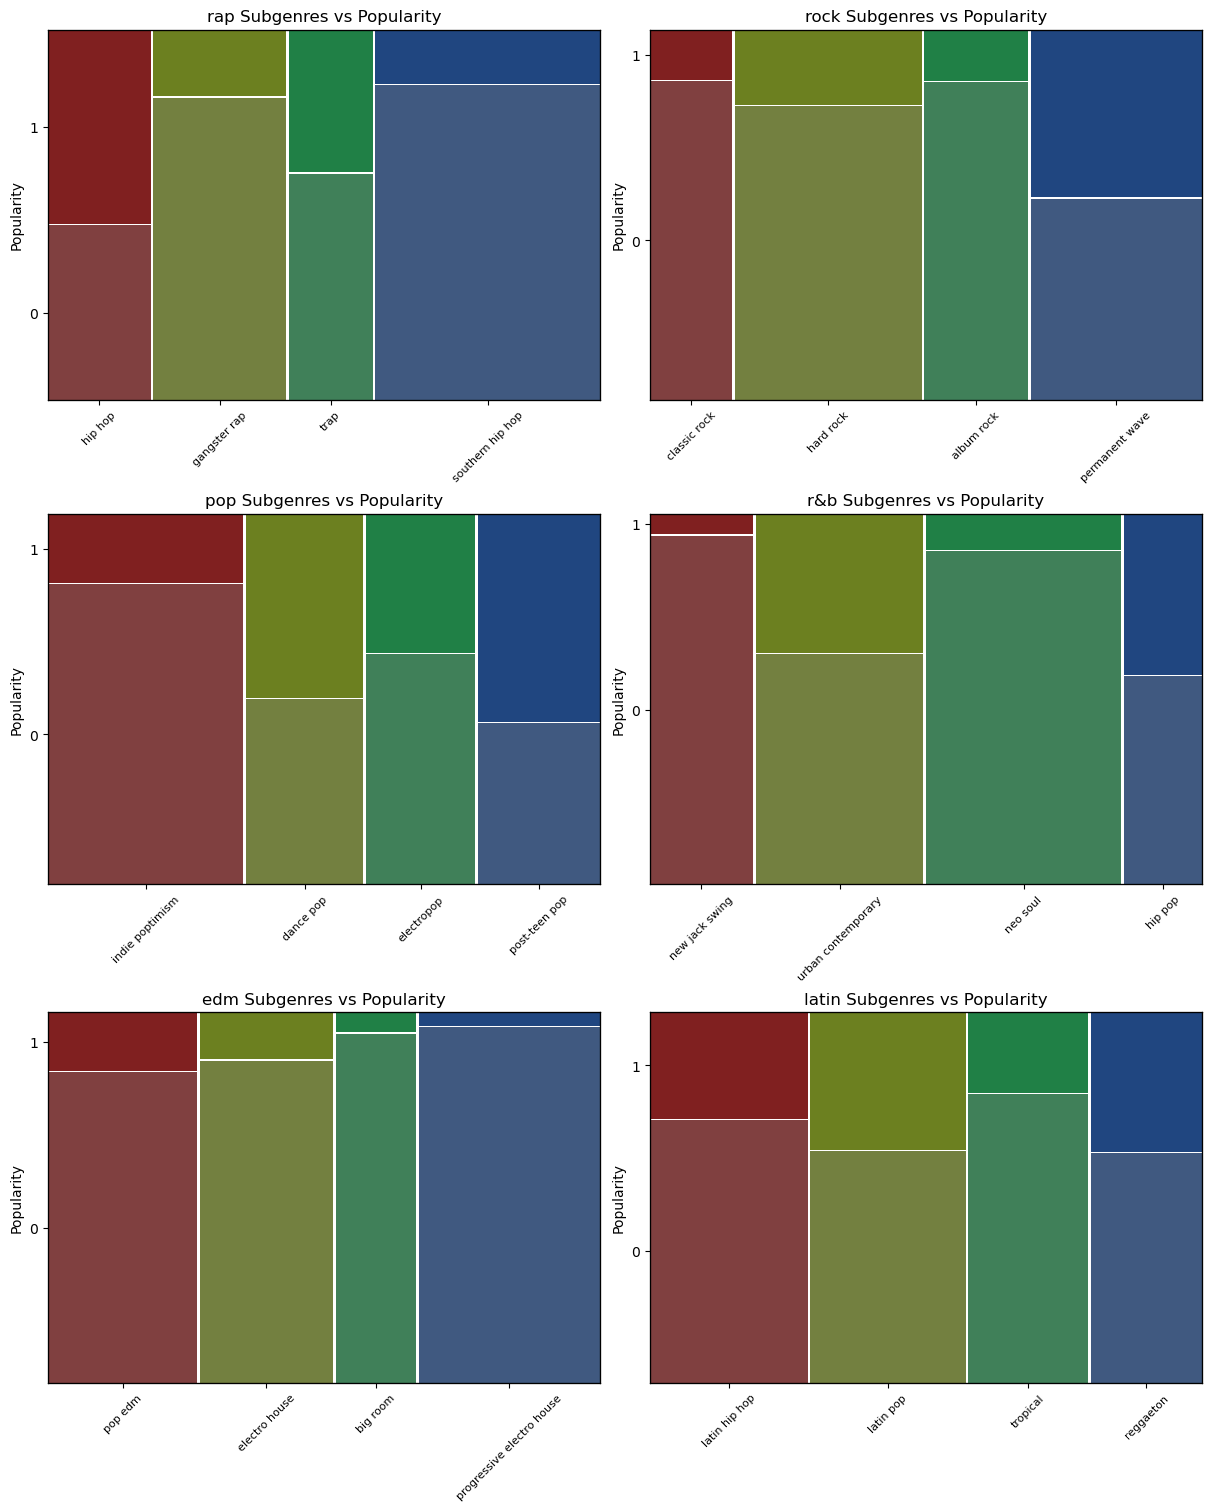

In [50]:
# Get unique playlist genres
unique_genres = df['playlist_genre'].unique()

# Determine the grid layout for the subplots
cols = 2  # Number of columns (you can adjust this)
rows = math.ceil(len(unique_genres) / cols)  # Calculate rows based on the number of genres

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 5), constrained_layout=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Create a mosaic plot for each playlist genre
for i, genre in enumerate(unique_genres):
    # Filter the DataFrame for the current genre
    genre_df = df[df['playlist_genre'] == genre]

    # Ensure subgenres are represented (replace missing subgenres if necessary)
    if 'playlist_subgenre' not in genre_df.columns:
        print(f"No subgenres found for {genre}, skipping.")
        axes[i].axis('off')  # Hide the unused subplot
        continue

    # Suppress subgenre names inside the mosaic plot
    def no_labels(key):
        return ""

    # Generate the mosaic plot on the current subplot
    mosaic(
        genre_df,
        ['playlist_subgenre', 'popular'],
        ax=axes[i],
        title=f'{genre} Subgenres vs Popularity',
        labelizer=no_labels
    )

    # Format subplot
    axes[i].set_ylabel('Popularity', fontsize=10)
    axes[i].tick_params(axis='x', rotation=45, labelsize=8)

# Hide any unused subplots
for j in range(len(unique_genres), len(axes)):
    axes[j].axis('off')  # Turn off unused subplots

# Display the plots
plt.show()

In [ ]:
# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 5), constrained_layout=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Create a box plot for each genre
for i, genre in enumerate(unique_genres):
    # Filter the DataFrame for the current genre
    genre_df = df[df['playlist_genre'] == genre]

    if genre_df['Topic'].nunique() < 2:  # Skip genres with fewer than 2 unique topics
        print(f"Skipping {genre} due to insufficient topic variety.")
        axes[i].axis('off')  # Hide the unused subplot
        continue

    # Generate the box plot for the current genre
    sns.boxplot(
        data=genre_df,
        x='Topic',
        y='popular',
        ax=axes[i]
    )
    axes[i].set_title(f'Box Plot: Popularity by Topic ({genre})', fontsize=12)
    axes[i].set_xlabel('Topic', fontsize=10)
    axes[i].set_ylabel('Popularity', fontsize=10)

# Hide any unused subplots
for j in range(len(unique_genres), len(axes)):
    axes[j].axis('off')  # Turn off unused subplots

# Display the plots
plt.show()

##### Topic
- In each genre, there is a variation of the average popularity for each topic. However the frequency of each topic varies and in some cases is not representative. This especially happens when there are song which have a mixture of topics which is normal in song lyrics.

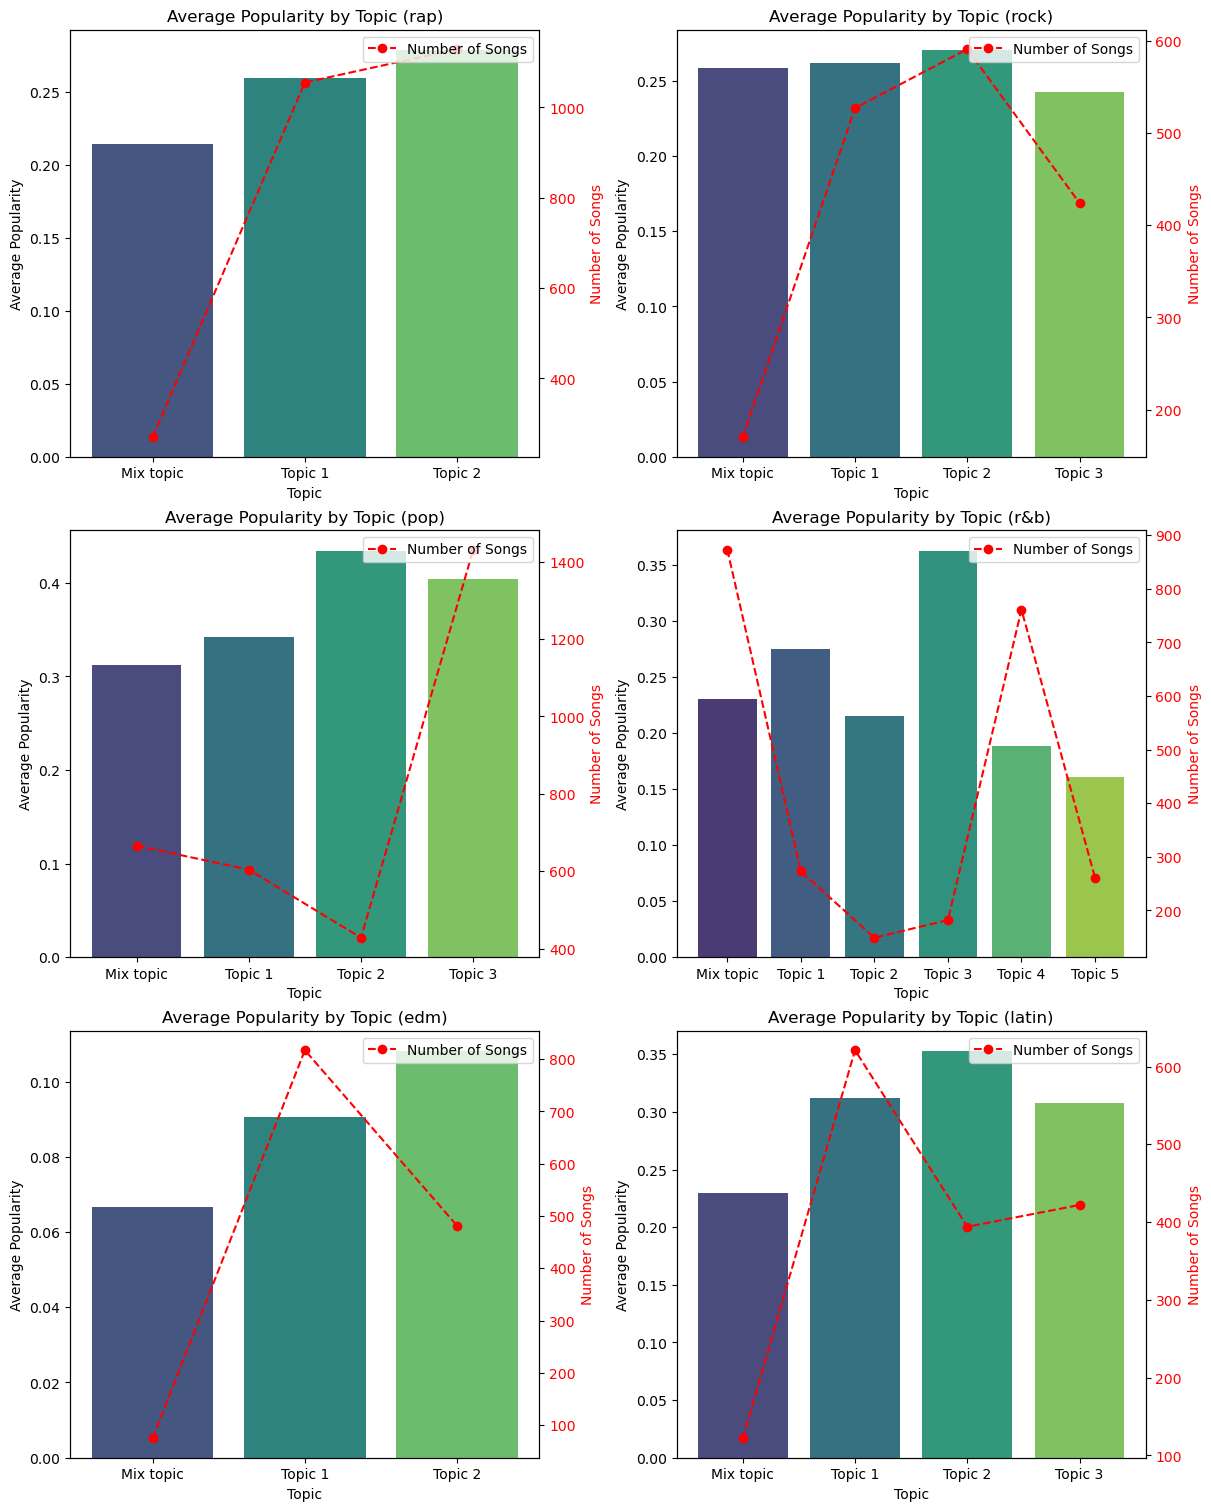

In [51]:
# Convert 'popular' to numeric
df['popular'] = pd.to_numeric(df['popular'], errors='coerce')
df = df.dropna(subset=['popular'])

# Unique genres in the dataset
unique_genres = df['playlist_genre'].unique()

# Determine layout for subplots
cols = 2
rows = (len(unique_genres) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 5), constrained_layout=True)

axes = axes.flatten()

# Create dual y-axis plots for each genre
for i, genre in enumerate(unique_genres):
    genre_df = df[df['playlist_genre'] == genre]

    if genre_df['Topic'].nunique() < 2:
        print(f"Skipping {genre} due to insufficient topic variety.")
        axes[i].axis('off')
        continue

    # Calculate the average popularity and number of songs per topic
    topic_summary = genre_df.groupby('Topic').agg(
        avg_popularity=('popular', 'mean'),
        num_songs=('popular', 'size')  # Number of songs per topic
    ).reset_index()

    # Create a bar chart for average popularity
    ax1 = axes[i]
    sns.barplot(
        data=topic_summary,
        x='Topic',
        y='avg_popularity',
        hue='Topic',  # Assign 'Topic' to hue
        ax=ax1,
        palette='viridis',
        dodge=False,  # Ensure a single set of bars
        legend=False  # Suppress the legend
    )
    ax1.set_title(f'Average Popularity by Topic ({genre})', fontsize=12)
    ax1.set_xlabel('Topic', fontsize=10)
    ax1.set_ylabel('Average Popularity', fontsize=10)

    # Create a secondary y-axis for the number of songs
    ax2 = ax1.twinx()
    ax2.plot(
        topic_summary['Topic'],
        topic_summary['num_songs'],
        color='red',
        marker='o',
        linestyle='--',
        label='Number of Songs'
    )
    ax2.set_ylabel('Number of Songs', fontsize=10, color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Add legend for the secondary axis
    ax2.legend(loc='upper right', fontsize=10)

# Hide any unused subplots
for j in range(len(unique_genres), len(axes)):
    axes[j].axis('off')

plt.show()



##### Sentiments
- The average popularity between positive and negative songs are the same. However the frequency of positive songs is higher than negative.

C:\Users\gpnc_\AppData\Local\Temp\ipykernel_21432\4273114033.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(data=sentiment_popularity, x='sentiment', y='avg_popularity', palette='viridis')


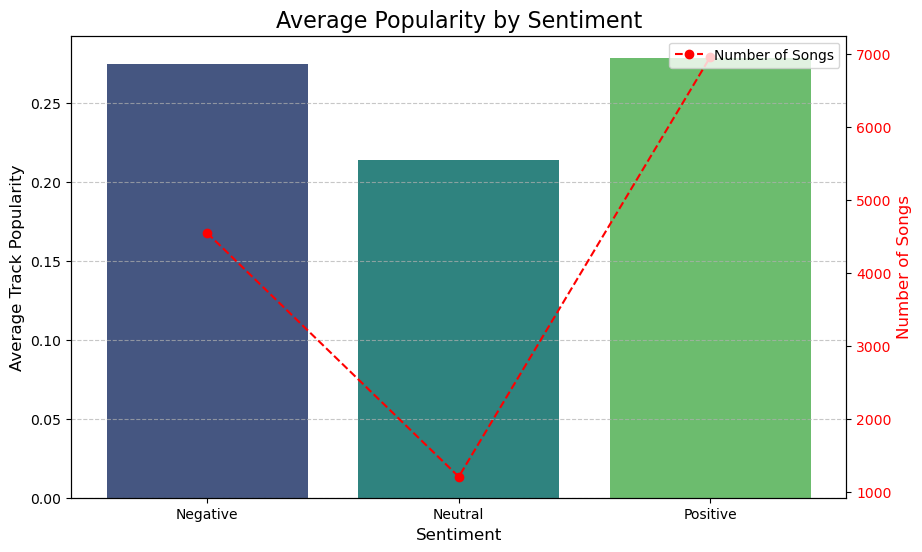

In [53]:
# Calculate average popularity and number of songs per sentiment
sentiment_popularity = df.groupby('sentiment').agg(
    avg_popularity=('popular', 'mean'),
    num_songs=('popular', 'size')  # Number of songs per sentiment
).reset_index()

plt.figure(figsize=(10, 6))

# Create a bar chart for average popularity
ax1 = sns.barplot(data=sentiment_popularity, x='sentiment', y='avg_popularity', palette='viridis')
ax1.set_title('Average Popularity by Sentiment', fontsize=16)
ax1.set_xlabel('Sentiment', fontsize=12)
ax1.set_ylabel('Average Track Popularity', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Create a secondary y-axis for the number of songs
ax2 = ax1.twinx()
ax2.plot(
    sentiment_popularity['sentiment'],
    sentiment_popularity['num_songs'],
    color='red',
    marker='o',
    linestyle='--',
    label='Number of Songs'
)
ax2.set_ylabel('Number of Songs', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add legend for the secondary axis
ax2.legend(loc='upper right', fontsize=10)

plt.xticks(rotation=45)
plt.show()

##### Emotions
- The average popularity among emotions vary. However the frequency per emotion as well, there is no a clear evidence if certain emotions affect more than other. Also the less frequent emotion is disgust

C:\Users\gpnc_\AppData\Local\Temp\ipykernel_21432\976654047.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(data=emotion_popularity, x='strongest_emotion', y='avg_popularity', palette='viridis')


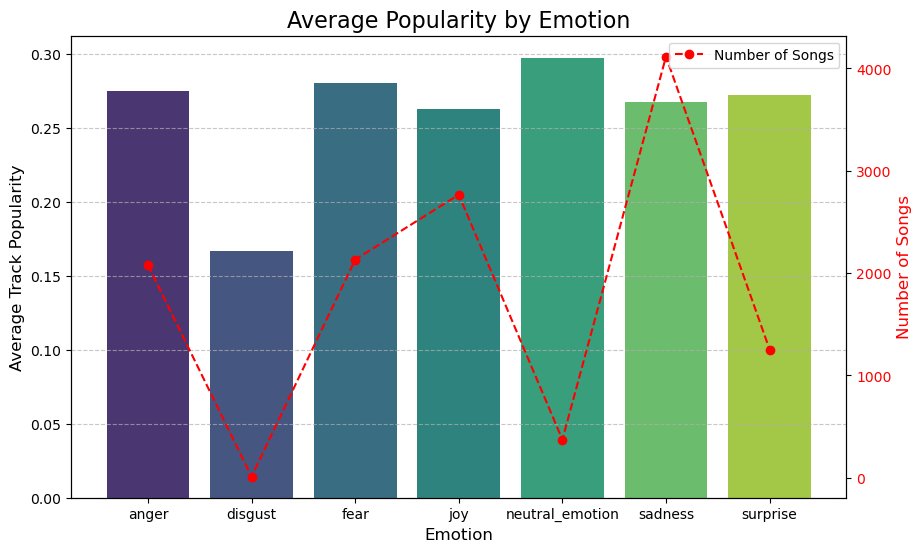

In [54]:
# Calculate average popularity and number of songs per emotion
emotion_popularity = df.groupby('strongest_emotion').agg(
    avg_popularity=('popular', 'mean'),
    num_songs=('popular', 'size')  # Number of songs per emotion
).reset_index()

plt.figure(figsize=(10, 6))

# Create a bar chart for average popularity
ax1 = sns.barplot(data=emotion_popularity, x='strongest_emotion', y='avg_popularity', palette='viridis')
ax1.set_title('Average Popularity by Emotion', fontsize=16)
ax1.set_xlabel('Emotion', fontsize=12)
ax1.set_ylabel('Average Track Popularity', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Create a secondary y-axis for the number of songs
ax2 = ax1.twinx()
ax2.plot(
    emotion_popularity['strongest_emotion'],
    emotion_popularity['num_songs'],
    color='red',
    marker='o',
    linestyle='--',
    label='Number of Songs'
)
ax2.set_ylabel('Number of Songs', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add legend for the secondary axis
ax2.legend(loc='upper right', fontsize=10)

plt.xticks(rotation=45)
plt.show()

#### 2.3 Numerical variables
- The violin plots indicate a very similar behavior between popular and unpopular songs. Therefore from this graphs is difficut to stablish any insight.

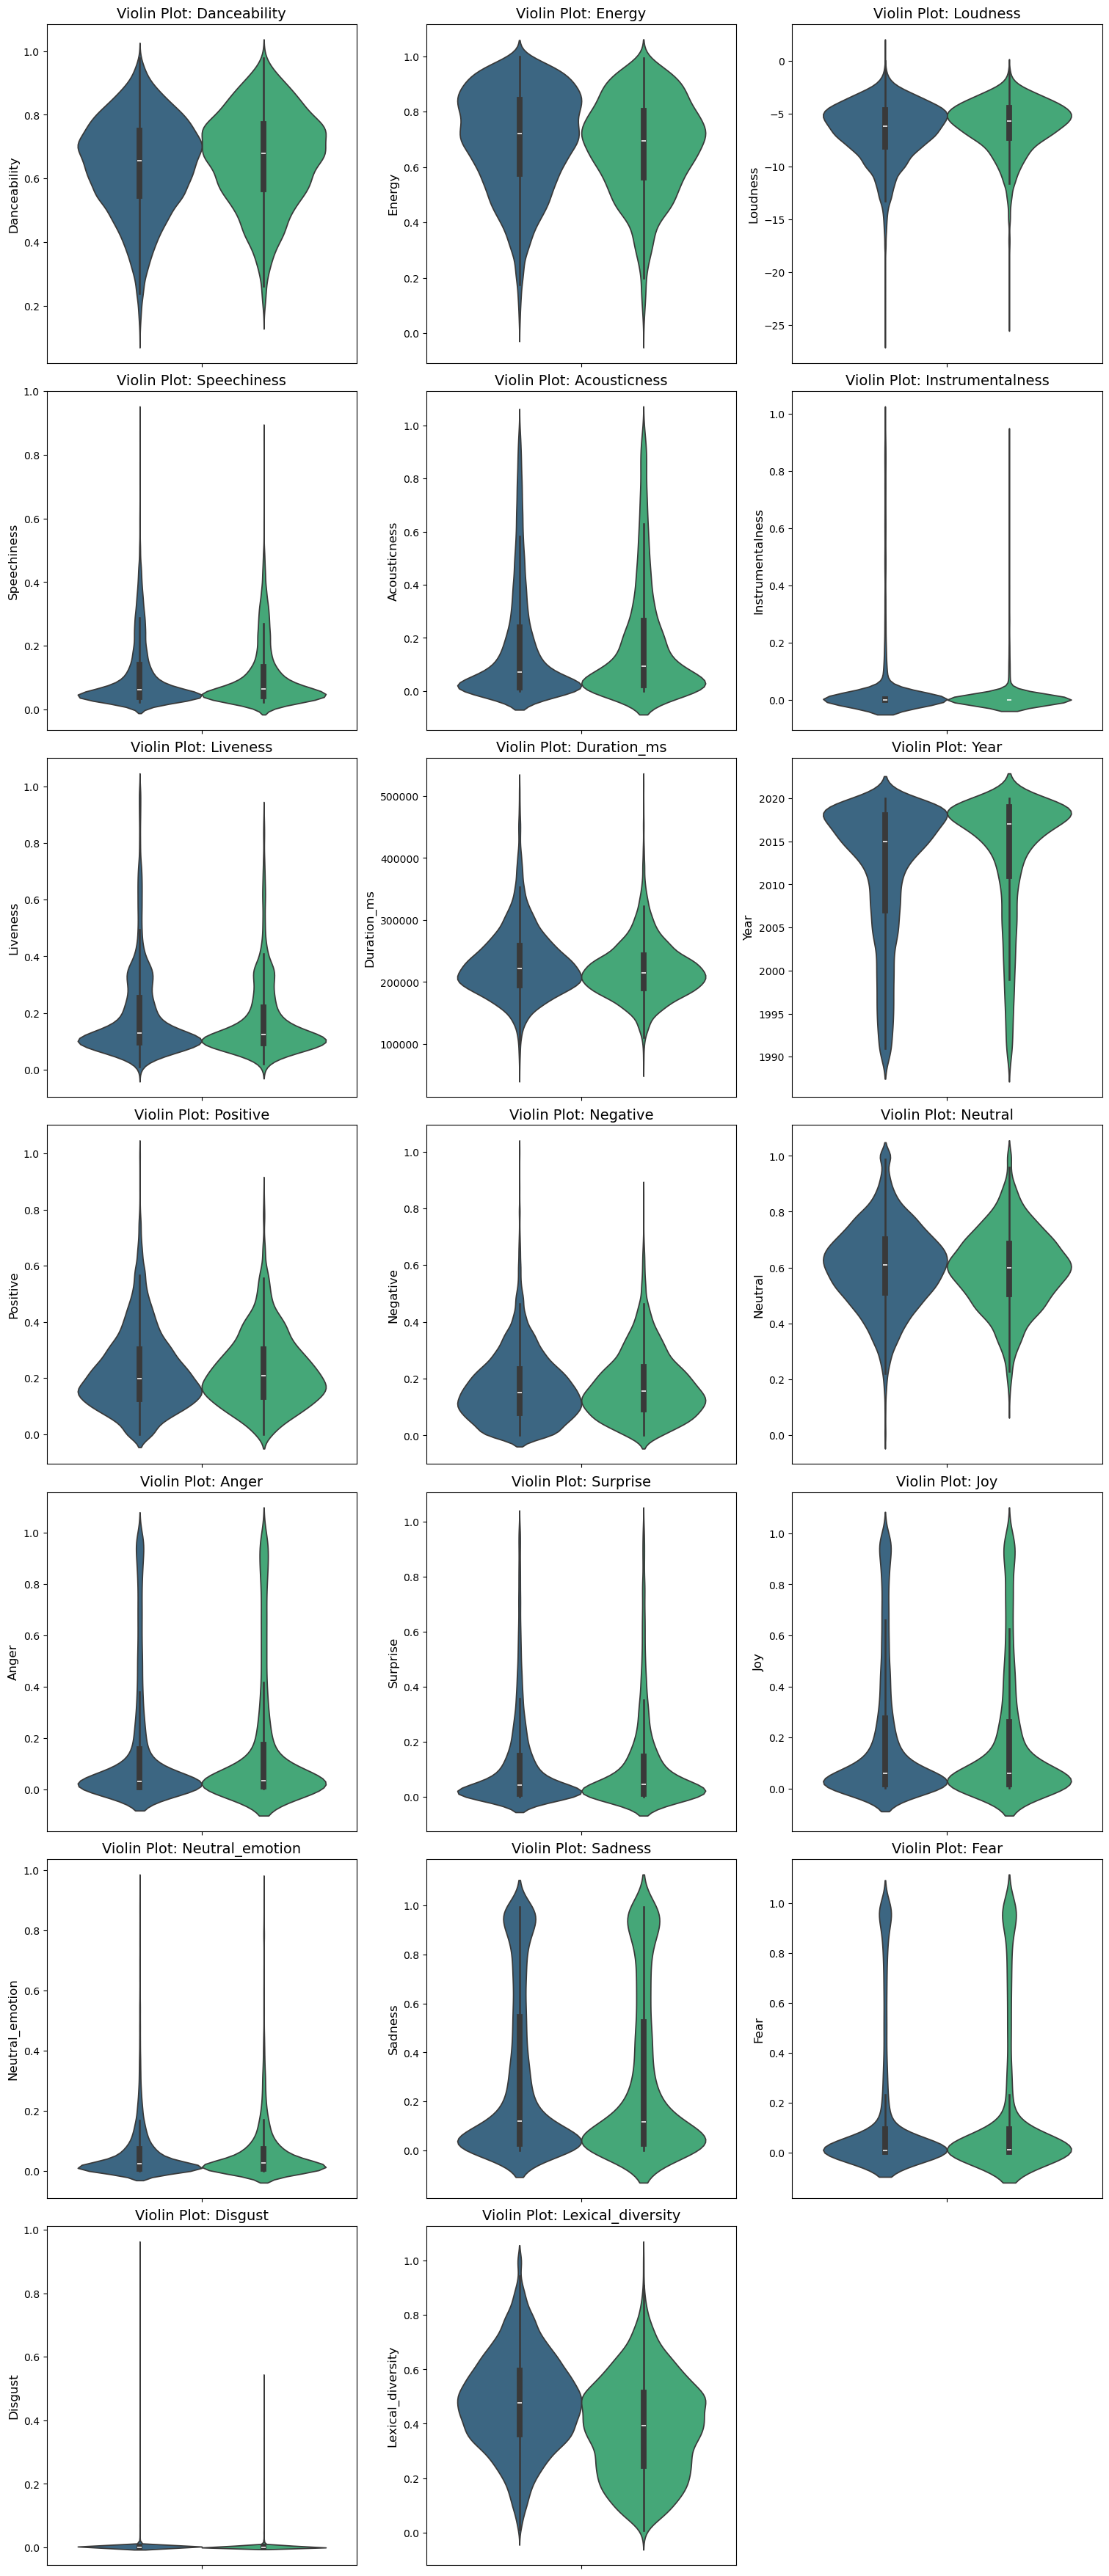

In [56]:
# Filter numeric columns
df_num = df.select_dtypes(include=['number'])

# Identify numeric columns excluding the binary target ('popular')
num_columns = [col for col in df_num.columns if col != 'popular']

# Create a figure and subplots
n_cols = 3  # Number of plots per row
n_rows = (len(num_columns) + n_cols - 1) // n_cols  # Determine rows based on number of columns
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), constrained_layout=True)

# Flatten axes for easy iteration
axes = axes.flatten()

# Create violin plots for each numerical variable
for idx, column in enumerate(num_columns):
    ax = axes[idx]  # Select the current subplot

    # Plot violin plot with updated parameters
    sns.violinplot(data=df, y=column, hue='popular', ax=ax, palette='viridis', legend=False)

    # Add titles and labels
    ax.set_title(f'Violin Plot: {column.capitalize()}', fontsize=14)
    ax.set_ylabel(column.capitalize(), fontsize=12)
    ax.set_xlabel('')

# Hide any unused subplots
for idx in range(len(num_columns), len(axes)):
    fig.delaxes(axes[idx])

# Show the plots
plt.show()



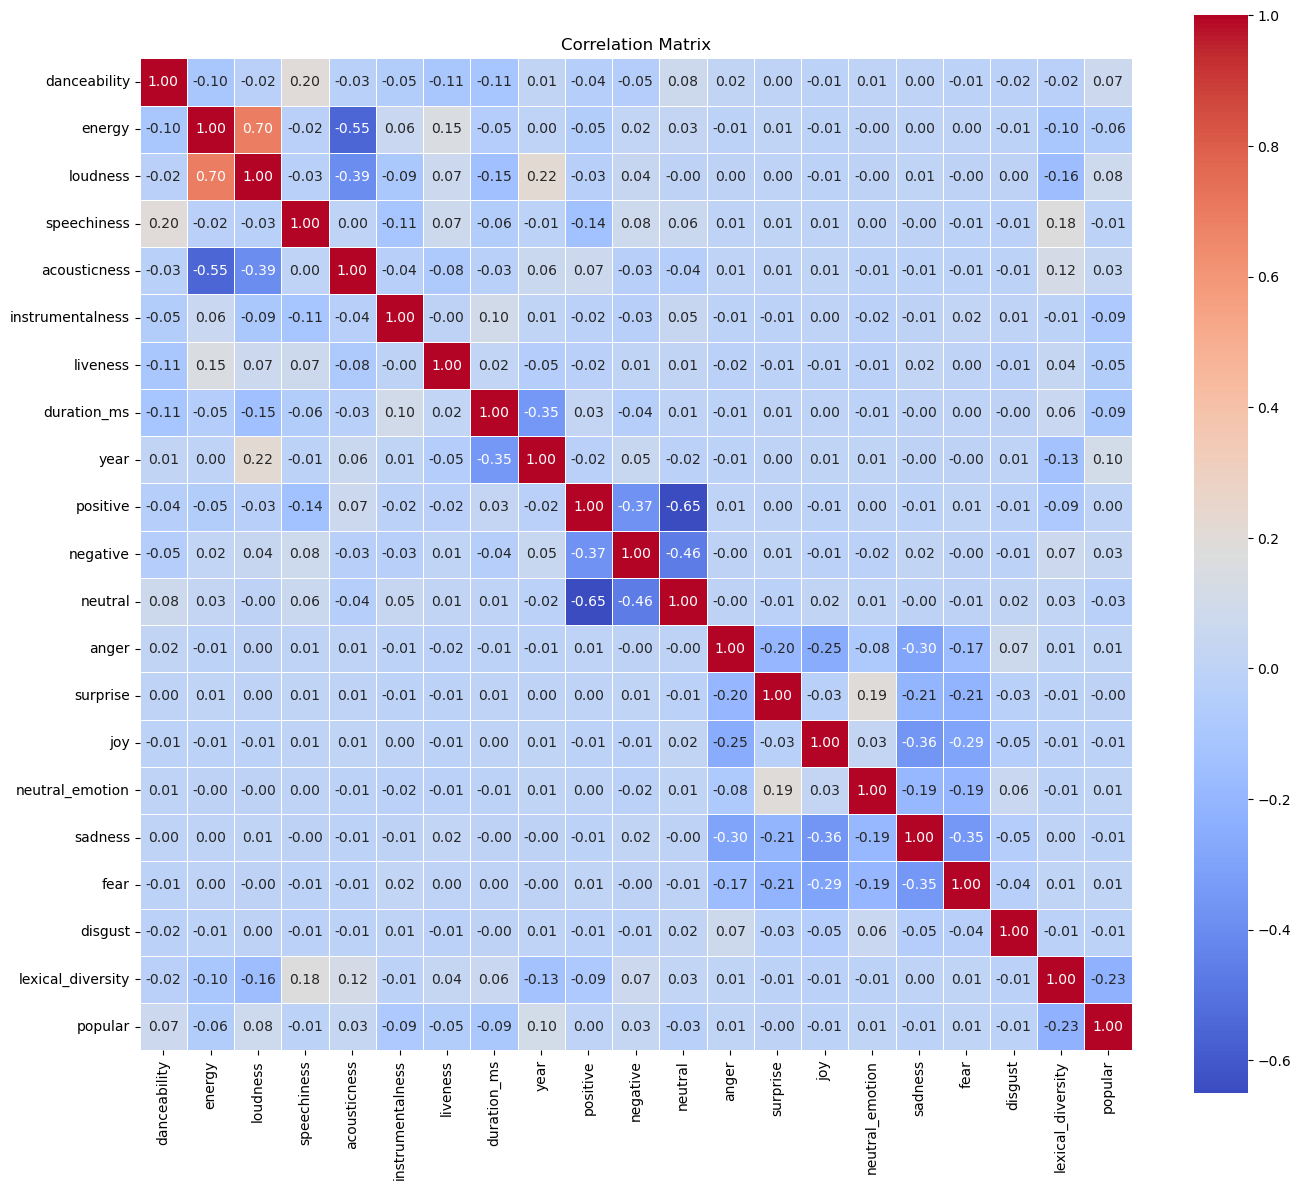

In [57]:
#Correlation matrix
df_num = df.select_dtypes(include=['number'])
#sp_dataset_num.describe()
correlation_matrix = df_num.corr()

# Set up the matplotlib figure
plt.figure(figsize=(16, 14))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.4)

# Add title and labels
plt.title('Correlation Matrix')
plt.show()


### 3. General Model
- The categorical variable like genre and subgenre will be dummyfy
- The isolation forest technique will allow us to remove outliers
- UnderSampler technique will help us to deal the imbalance data for the target variable

In [96]:
#Drop irrelevant variables
sel_df = df.drop(columns=['track_artist','neutral_emotion','strongest_emotion','Topic','sentiment'])
    #For this selection Topic will be dropped because that feature is only applicable for each genre

# Reset the DataFrame index
sel_df.index = np.arange(0, len(sel_df))

#Dummyfing
y=sel_df['popular']
X=sel_df.drop(columns=['popular'], axis=1)
X=pd.get_dummies(X, drop_first=True) #Baseline of genre and subgenre

#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#Isolation Forest to remove outliers
iforest = IsolationForest(n_estimators=100, contamination=.05)
pred=iforest.fit(X_train)
outliers_train = pred.predict(X_train)
outliers_test = pred.predict(X_test)
outliers_value_train = outliers_train != -1
outliers_value_test = outliers_test != -1

X_train=X_train[outliers_value_train]
y_train=y_train[outliers_value_train]
X_test=X_test[outliers_value_test]
y_test=y_test[outliers_value_test]

#Balance the data
rus = RandomUnderSampler(random_state=0)
X_train, y_train= rus.fit_resample(X_train, y_train)

#Standarize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


#### Random Forest General Model
- Predicting Not popular songs
    - High precision (87%) indicates that most songs predicted as not popular are indeed not popular.
    - Moderate recall (72%) suggests the model identifies most, but not all, non-popular songs.
- Predicting Popular songs
    - Lower precision (49%) indicates that nearly half of the songs predicted as popular are incorrectly classified.
    - Moderate recall (72%) shows that the model captures most of the truly popular songs but may misclassify others.

- Feature importance: 
    - Top predictors: 
        - Lexical Diversity (0.094): The most influential feature, indicating that the diversity of words in lyrics significantly impacts the model's ability to predict a song's popularity.
        - Energy (0.050): Energy levels in audio, such as intensity or perceived activity, are crucial for determining popularity.
        - Year (0.049): The release year of a song contributes to its relevance and popularity.
        - Loudness (0.048): How loud a track is also affects its popularity prediction.
    - Audio feature dominance:
        - Key audio features such as danceability (0.046), acousticness (0.044), and speechiness (0.043) rank among the top features, emphasizing the importance of sonic characteristics in predicting song popularity.
    - Emotional and Sentiment Factors:
        - Emotions derived from lyrics, such as negative sentiment (0.043), positive sentiment (0.041), and specific emotions like disgust (0.039), sadness (0.039), and joy (0.037), also play a significant role.
    - Lower influence of genres and subgenres


In [97]:
#Random Forest
rf = RandomForestClassifier(random_state=0)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [20, 30],
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='recall', cv=5, verbose=2)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Parameters:", best_params) #

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Random Forest")
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .....................max_depth=20, n_estimators=100; total time=   1.2s
[CV] END .....................max_depth=20, n_estimators=100; total time=   1.2s
[CV] END .....................max_depth=20, n_estimators=100; total time=   1.2s
[CV] END .....................max_depth=20, n_estimators=100; total time=   1.2s
[CV] END .....................max_depth=20, n_estimators=100; total time=   1.3s
[CV] END .....................max_depth=20, n_estimators=200; total time=   2.7s
[CV] END .....................max_depth=20, n_estimators=200; total time=   2.7s
[CV] END .....................max_depth=20, n_estimators=200; total time=   3.4s
[CV] END .....................max_depth=20, n_estimators=200; total time=   5.4s
[CV] END .....................max_depth=20, n_estimators=200; total time=   5.4s
[CV] END .....................max_depth=30, n_estimators=100; total time=   2.9s
[CV] END .....................max_depth=30, n_est

                                        Feature  Importance
18                            lexical_diversity    0.094190
1                                        energy    0.050328
8                                          year    0.048614
2                                      loudness    0.048200
0                                  danceability    0.046153
4                                  acousticness    0.044171
7                                   duration_ms    0.043253
3                                   speechiness    0.042936
10                                     negative    0.042557
9                                      positive    0.040935
5                              instrumentalness    0.040805
6                                      liveness    0.039660
17                                      disgust    0.039438
11                                      neutral    0.039329
15                                      sadness    0.039308
13                                     s

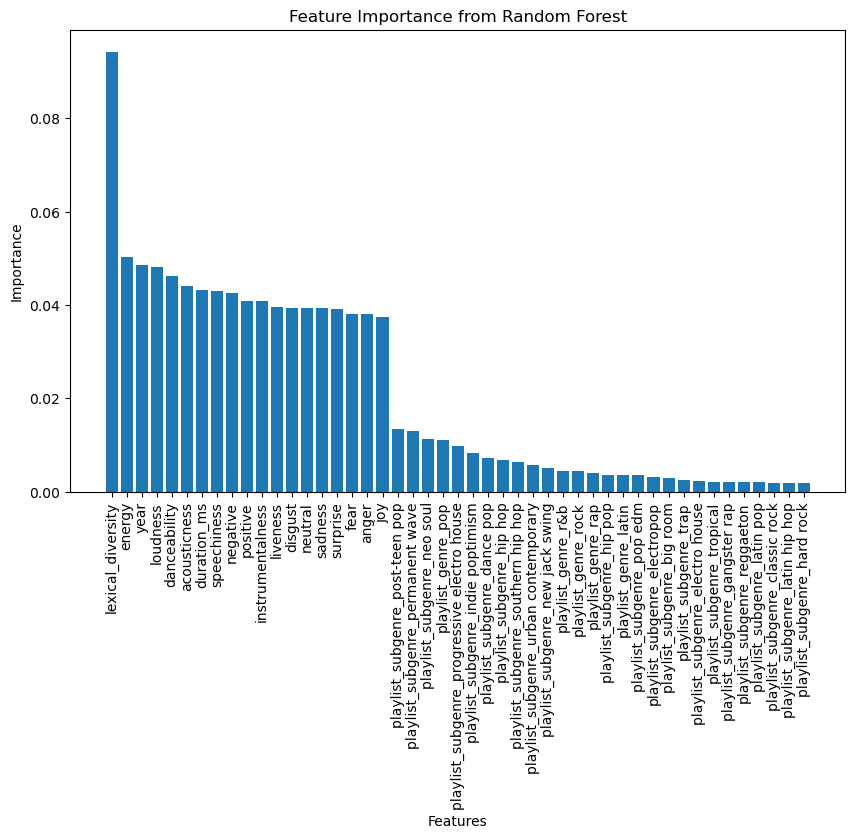

In [98]:
#Feature importance insights and graph

importances = best_rf.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)

plt.figure(figsize=(10, 6))
plt.bar(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance from Random Forest')
plt.xticks(rotation=90)
plt.show()

#### Logistic regression General Model
1. Model Performance: slightly lower than Random forest model
    - Not popular songs: High precision (87%) but moderate recall (69%), indicating that while the model correctly identifies most non-popular songs, it misses some.
    - Popular songs: Precision (47%) is low, but recall (73%) is good, meaning the model captures popular songs but with more false positives.

2. Feature importance: 
    - Positive Predictors:
        - Loudness: Most significant positive predictor (Odds Ratio = 1.55), suggesting louder songs are more likely to be popular.
        - Playlist Subgenres: "Permanent Wave" (1.46), "Post-Teen Pop" (1.26), and "Hip Hop" (1.22) also positively influence popularity.
        - Danceability and Acousticness: Songs with higher danceability and acoustic qualities are associated with higher popularity.
    - Negative predictors:
        - Lexical Diversity: Strongest negative predictor (Odds Ratio = 0.55), indicating songs with diverse lyrics are less likely to be popular.
        - Energy: Lower energy levels (Odds Ratio = 0.61) reduce popularity.
        - Emotions: Sadness, joy, and disgust are associated with lower popularity.
3. Roc Curve:
    - AUC = 0.78: The model has a fair ability to differentiate between popular and non-popular songs. The ROC curve indicates good model performance, particularly at certain thresholds.



Accuracy: 0.7025
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.69      0.77      2645
           1       0.47      0.73      0.57       985

    accuracy                           0.70      3630
   macro avg       0.67      0.71      0.67      3630
weighted avg       0.76      0.70      0.72      3630



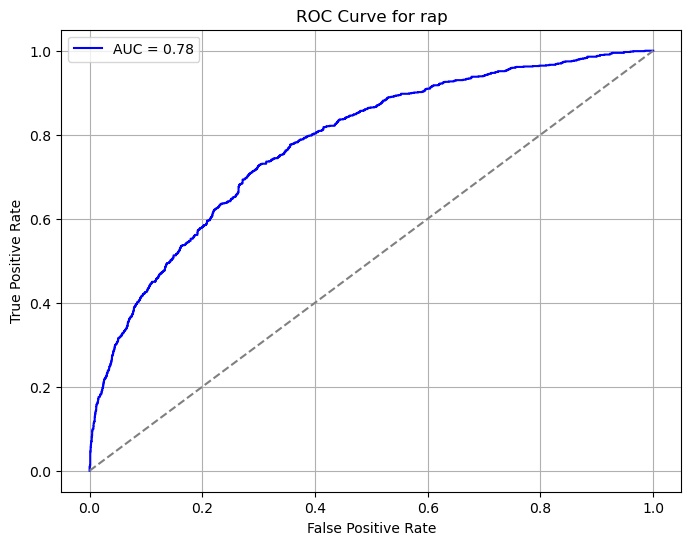

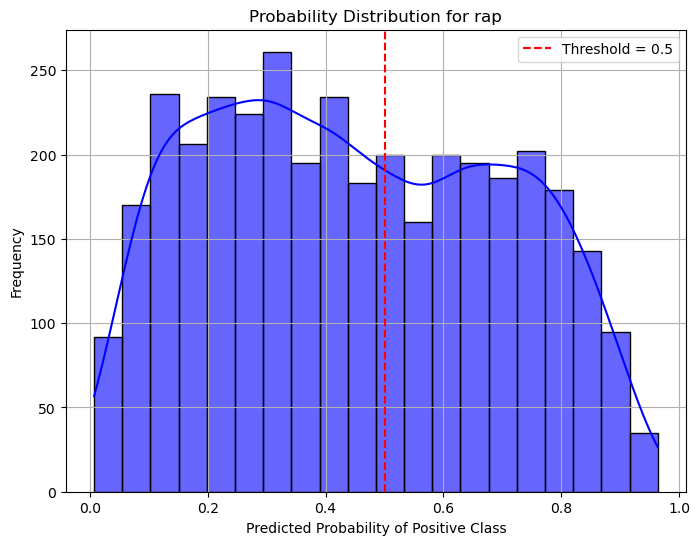

Top Features for rap:
                                             Coefficient  Odds Ratio
loudness                                        0.439544    1.552000
playlist_subgenre_permanent wave                0.382406    1.465807
playlist_subgenre_post-teen pop                 0.236434    1.266724
playlist_subgenre_hip hop                       0.201084    1.222727
playlist_subgenre_hip pop                       0.191627    1.211219
playlist_subgenre_urban contemporary            0.184882    1.203077
playlist_subgenre_dance pop                     0.141081    1.151518
danceability                                    0.137911    1.147873
playlist_genre_pop                              0.136670    1.146450
playlist_subgenre_trap                          0.111299    1.117729
playlist_subgenre_reggaeton                     0.100851    1.106111
acousticness                                    0.091733    1.096073
negative                                        0.091009    1.095279
playlist_sub

In [ ]:
#Logistic Regression with ridge

lr=LogisticRegression(penalty='l2',C=12, solver='lbfgs')

# Fit the model
lr.fit(X_train, y_train)
threshold=0.5

# Get predicted probabilities
probabilities = lr.predict_proba(X_test)
    
# Adjust the threshold for binary classification
predictions = (probabilities[:, 1] >= threshold).astype(int)
    
# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions, output_dict=True)
    
# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Classification Report:\n", classification_report(y_test, predictions))

# --- 1. ROC Curve and AUC ---
fpr, tpr, thresholds = roc_curve(y_test, probabilities[:, 1])
auc_score = roc_auc_score(y_test, probabilities[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title(f"ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

# --- 3. Probability Distribution ---
plt.figure(figsize=(8, 6))
sns.histplot(probabilities[:, 1], bins=20, kde=True, color="blue", alpha=0.6)
plt.axvline(threshold, color="red", linestyle="--", label=f"Threshold = {threshold}")
plt.title(f"Probability Distribution")
plt.xlabel("Predicted Probability of Positive Class")
plt.ylabel("Frequency")
plt.legend()
plt.grid()
plt.show()

# --- 2. Coefficients and Odds Ratios ---
coefficients = lr.coef_[0]
odds_ratios = pd.Series(np.exp(coefficients), index=feature_names)

coeffs_df = pd.DataFrame({
        "Coefficient": coefficients,
        "Odds Ratio": odds_ratios
    }).sort_values(by="Coefficient", ascending=False)

print(f"Top Features for {genre}:")
print(coeffs_df)




#### Conclusions General Model
- Key predictor of popularity:
    - Audio features (loudness, danceability, energy) are strong drivers of song popularity, with louder and more danceable tracks being favored.
    - Lyrics and emotions: 
        - Lexical diversity (complexity of lyrics) negatively impacts popularity, indicating simpler, repetitive lyrics resonate better with audiences.
        - Specific emotions like disgust and sadness influence negative song popularity but to a lesser extent.

- Model insights:
    - Random Forest: Provides better precision for identifying non-popular songs but struggles with popular songs. Logistic regression doesnt improve this

- Importance of genre and subgenre:
    - While audio and lyrical features dominate, playlist genres and subgenres like "Hip Hop," "Dance Pop," and "Post-Teen Pop" contribute moderately to song popularity.
    - Subgenres with lower odds ratios ("Neo Soul," "Indie Poptimism") may appeal to niche audiences and are less likely to produce universally popular hits.

- Improvements:
    - Both models struggle with class imbalance, as popular songs are underrepresented in the dataset, leading to lower precision in identifying them.
    - Improve lyrics analysis to determinate more clear patters like key words, or pharses that can influence the popularity

- Implications for Songwriters and the Music Industry
    - Optimize audio features and focus on enhancing danceability, loudness, and energy in their tracks to appeal to a wider audience.
    - Simplify lyrics, simplistic and repetitive lyrics tend to resonate more with audiences, making the song easier to remember and more engaging.
    - Focus on high impact subgenres, genres like dance pop, hip hop, and post-teen pop have a stronger association with popularity. Targeting these subgenres could maximize the commercial success of songs
    - Leverage data driven insights, the music industry could use similar machine learning models to refine marketing strategies, tailor playlists, and predict hit songs.
    

### 4. Modelling for each genre

In [112]:
# 4.1 Split, balance and remove outliers
def process_genre_data(df, genre, drop_columns=['track_artist', 'neutral_emotion', 'playlist_genre', 'strongest_emotion', 'sentiment']):
    """
    Processes the data for a specific genre: split, balance, and remove outliers.

    Args:
        df: DataFrame containing the dataset.
        genre: The genre to filter and process.
        drop_columns: List of columns to drop from the DataFrame.

    Returns:
        X_train, X_test, y_train, y_test, feature_names: Processed train-test split and feature names.
    """
    print(f"Processing data for genre: {genre}")

    # Filter the DataFrame for the specific genre
    genre_df = df[df['playlist_genre'] == genre].copy()

    # Drop irrelevant variables
    final_df = genre_df.drop(columns=drop_columns, errors='ignore')

    # Reset the DataFrame index
    final_df.index = np.arange(0, len(final_df))

    # Dummyfying
    y = final_df['popular']
    X = final_df.drop(columns=['popular'], axis=1)
    X = pd.get_dummies(X, drop_first=True)  # Baseline of genre, subgenre, and topic

    # Save feature names before any transformation
    feature_names = X.columns

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    # Isolation Forest to remove outliers
    iforest = IsolationForest(n_estimators=100, contamination=.05)
    pred = iforest.fit(X_train)
    outliers_train = pred.predict(X_train)
    outliers_test = pred.predict(X_test)
    outliers_value_train = outliers_train != -1
    outliers_value_test = outliers_test != -1

    X_train = X_train[outliers_value_train]
    y_train = y_train[outliers_value_train]
    X_test = X_test[outliers_value_test]
    y_test = y_test[outliers_value_test]

    # Balance the data
    rus = RandomUnderSampler(random_state=0)
    X_train, y_train = rus.fit_resample(X_train, y_train)

    # Standardize
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test, feature_names

#### Model 1: Random Forest

In [114]:
def analyze_genre(df, genre, param_grid, X_train, X_test, y_train, y_test, feature_names, threshold=0.5):
    """
    Analyze a specific genre using a Random Forest model.
    
    Args:
        df (pd.DataFrame): The DataFrame containing the dataset.
        genre (str): The genre to analyze.
        param_grid (dict): Parameters for Random Forest hyperparameter tuning.
        threshold (float): Classification threshold.
    
    Returns:
        dict: Results including feature importance, accuracy, and classification report.
    """
    print("Random Forest:")
    print(f"Processing Genre: {genre}")
   
    # Initialize Random Forest
    rf = RandomForestClassifier(random_state=0)

    # Perform Grid Search for hyperparameter tuning
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='recall', cv=5, verbose=2)
    grid_search.fit(X_train, y_train)

    # Best parameters and model
    best_params = grid_search.best_params_
    best_rf = grid_search.best_estimator_

    print(f"Best Parameters for {genre}:", best_params)

    # Get predicted probabilities
    probabilities = best_rf.predict_proba(X_test)

    # Adjust the threshold for binary classification
    predictions = (probabilities[:, 1] >= threshold).astype(int)

    # Evaluate the model
    accuracy = accuracy_score(y_test, predictions)
    report = classification_report(y_test, predictions, output_dict=True)

    # Print results
    print(f"Accuracy for {genre}: {accuracy:.4f}")
    print(f"Classification Report for {genre}:\n", classification_report(y_test, predictions))

    # Plot Feature Importance
    feature_importances = best_rf.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]  # Sort features by importance (descending)
    #top_features = sorted_idx[:10]  # Display top 10 features

    plt.figure(figsize=(10, 6))
    plt.barh(np.array(feature_names)[sorted_idx], feature_importances[sorted_idx], color='skyblue')
    plt.title(f"Feature Importance ({genre})", fontsize=14)
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Return results as a dictionary
    return {
        'best_params': best_params,
        'accuracy': accuracy,
        'classification_report': report,
        'feature_importances': dict(
            zip(np.array(feature_names)[top_features], feature_importances[top_features])
        )
    }

#### Model 2: Logistic Regression

In [116]:
#Logistic Regression

# Threshold for binary classification
threshold = 0.5

def analyze_logistic_regression(df,genre, X_train, X_test, y_train, y_test, feature_names, threshold = 0.5 ):

    print("Logistic Regression:")
    print(f"Processing Genre: {genre}")
          
    # Initialize Logistic Regression with default parameters
    lr = LogisticRegression(random_state=0)
    
    # Fit the model
    lr.fit(X_train, y_train)
    
    # Get predicted probabilities
    probabilities = lr.predict_proba(X_test)
    
    # Adjust the threshold for binary classification
    predictions = (probabilities[:, 1] >= threshold).astype(int)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, predictions)
    report = classification_report(y_test, predictions, output_dict=True)
    
    # Print results
    print(f"Accuracy for {genre}: {accuracy:.4f}")
    print(f"Classification Report for {genre}:\n", classification_report(y_test, predictions))
    
    # --- 1. ROC Curve and AUC ---
    fpr, tpr, thresholds = roc_curve(y_test, probabilities[:, 1])
    auc_score = roc_auc_score(y_test, probabilities[:, 1])

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}", color="blue")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.title(f"ROC Curve for {genre}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid()
    plt.show()

        # --- 3. Probability Distribution ---
    plt.figure(figsize=(8, 6))
    sns.histplot(probabilities[:, 1], bins=20, kde=True, color="blue", alpha=0.6)
    plt.axvline(threshold, color="red", linestyle="--", label=f"Threshold = {threshold}")
    plt.title(f"Probability Distribution for {genre}")
    plt.xlabel("Predicted Probability of Positive Class")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid()
    plt.show()

    # --- 2. Coefficients and Odds Ratios ---
    coefficients = lr.coef_[0]
    odds_ratios = pd.Series(np.exp(coefficients), index=feature_names)

    coeffs_df = pd.DataFrame({
        "Coefficient": coefficients,
        "Odds Ratio": odds_ratios
    }).sort_values(by="Coefficient", ascending=False)

    print(f"Top Features for {genre}:")
    print(coeffs_df)


### 5. Results of modelling for each genre

#### 5.1 Rap
- 1. Model:
    - Logistic Regression slightly outperforms Random Forest in accuracy, indicating better generalization for this dataset.
    - Logistic Regression achieves better precision (50%) and similar recall (72%) compared to Random Forest, reducing false positives while maintaining detection rates for popular songs.

- 2. Feature importance and direction:
    - Lexical diversity is the most important feature, and with a negative coefficient confirmas that a lowe lexical diversity is associated with popular songs
    - Loudness and year: louder and newer songs positive correlated with higher popularity.
    - Danceability: Highly relevant across models, indicating danceable rap songs resonate with audiences.
    - Subgenre hip hop  are significant positive predictors of popularity
    - Sentiment, topic and emotions are not clearly relevant predictors in rap music


Processing data for genre: rap
Random Forest:
Processing Genre: rap
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=20, n_estimators=200; total time=   0.3s
[CV] END .....................max_depth=20, n_estimators=200; total time=   0.3s
[CV] END .....................max_depth=20, n_estimators=200; total time=   0.3s
[CV] END .....................max_depth=20, n_estimators=200; total time=   0.3s
[CV] END .....................max_depth=20, n_estimators=200; total time=   0.3s
[CV] END .....................max_depth=30, n_estimators=100; 

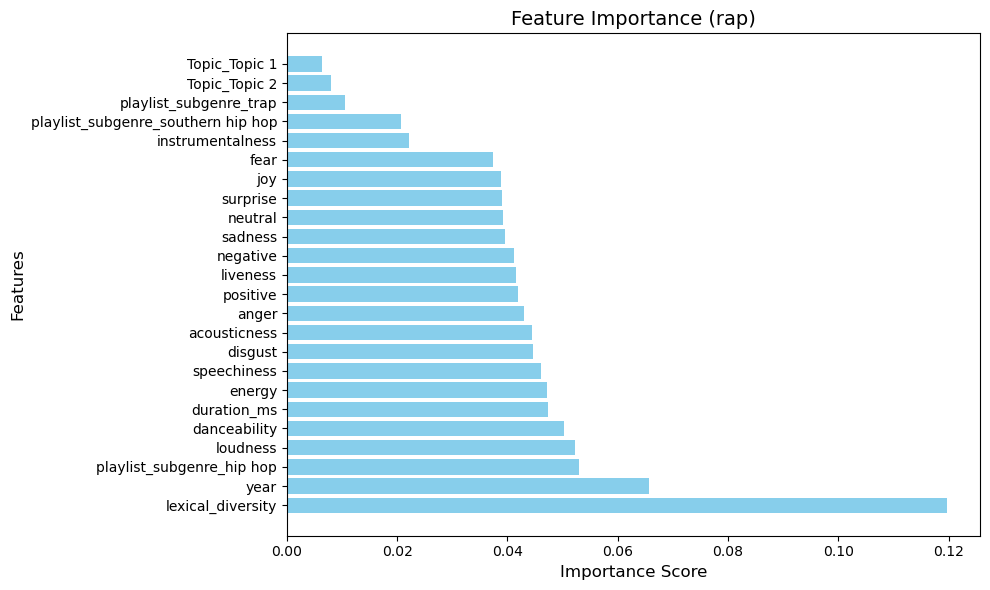

In [122]:
# Parameters for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [20, 30],
}

# Process data for the selected genre and retrieve feature names
X_train, X_test, y_train, y_test, feature_names = process_genre_data(df, 'rap')

# Analyze the genre "rock"
rock_results = analyze_genre(df, 'rap', param_grid, X_train, X_test, y_train, y_test, feature_names, threshold=0.5)

Logistic Regression:
Processing Genre: rap
Accuracy for rap: 0.7174
Classification Report for rap:
               precision    recall  f1-score   support

           0       0.87      0.72      0.78       502
           1       0.50      0.72      0.59       195

    accuracy                           0.72       697
   macro avg       0.68      0.72      0.69       697
weighted avg       0.76      0.72      0.73       697



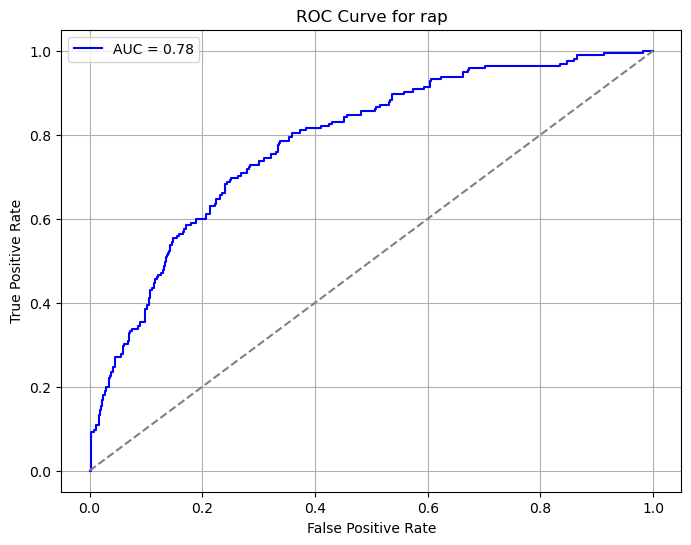

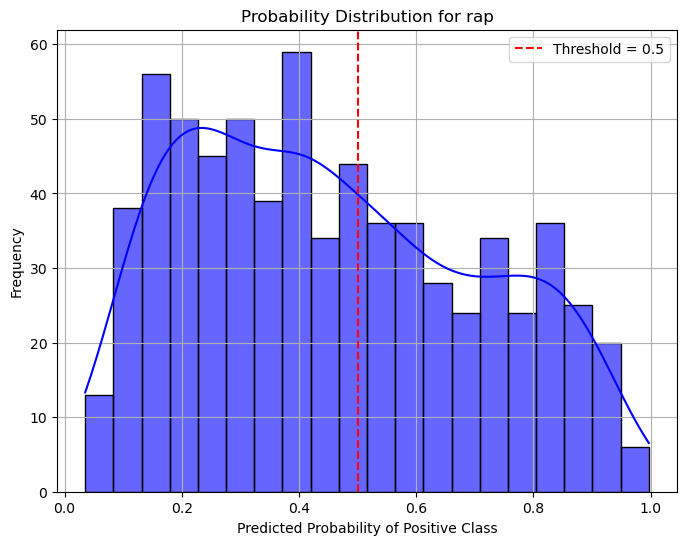

Top Features for rap:
                                    Coefficient  Odds Ratio
playlist_subgenre_hip hop              0.576634    1.780037
disgust                                0.285906    1.330967
playlist_subgenre_trap                 0.258797    1.295371
danceability                           0.253364    1.288352
loudness                               0.240244    1.271560
year                                   0.236703    1.267064
sadness                                0.160908    1.174577
anger                                  0.158822    1.172129
Topic_Topic 2                          0.116385    1.123429
positive                               0.101813    1.107176
fear                                   0.100682    1.105925
duration_ms                            0.080774    1.084126
instrumentalness                       0.068153    1.070529
joy                                    0.056001    1.057599
surprise                               0.037967    1.038697
negative          

In [123]:
#Rap
analyze_logistic_regression(df, 'rap', X_train, X_test, y_train, y_test, feature_names, threshold = 0.5 )

#### 5.2. Rock
- 1. Model: Randome Forest perfom a little better than logistic regression
    - The models have a higher recall but at the cost of more false positives (lower precision)
    - The ROC curve shows a moderate discriminatory ability

- 2. Feature importance: 
    - Year: The most important predictor, indicating older songs are more likely to be popular (negative correlation confirmed by Logistic Regression coefficient: -0.90).
    - Lexical Diversity: Songs with simpler lyrics (lower diversity) are associated with higher popularity.
    - Playlist Subgenre: "Permanent Wave" significantly predicts popularity.
    - Loudness and Danceability: Louder and more danceable rock songs resonate with listeners.
    - sentiments and emotions are moderate predictors but less significant compared to audio features like Loudness and Danceability.

Processing data for genre: rock
Random Forest:
Processing Genre: rock
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=20, n_estimators=200; total time=   0.2s
[CV] END .....................max_depth=20, n_estimators=200; total time=   0.2s
[CV] END .....................max_depth=20, n_estimators=200; total time=   0.3s
[CV] END .....................max_depth=20, n_estimators=200; total time=   0.2s
[CV] END .....................max_depth=20, n_estimators=200; total time=   0.2s
[CV] END .....................max_depth=30, n_estimators=100

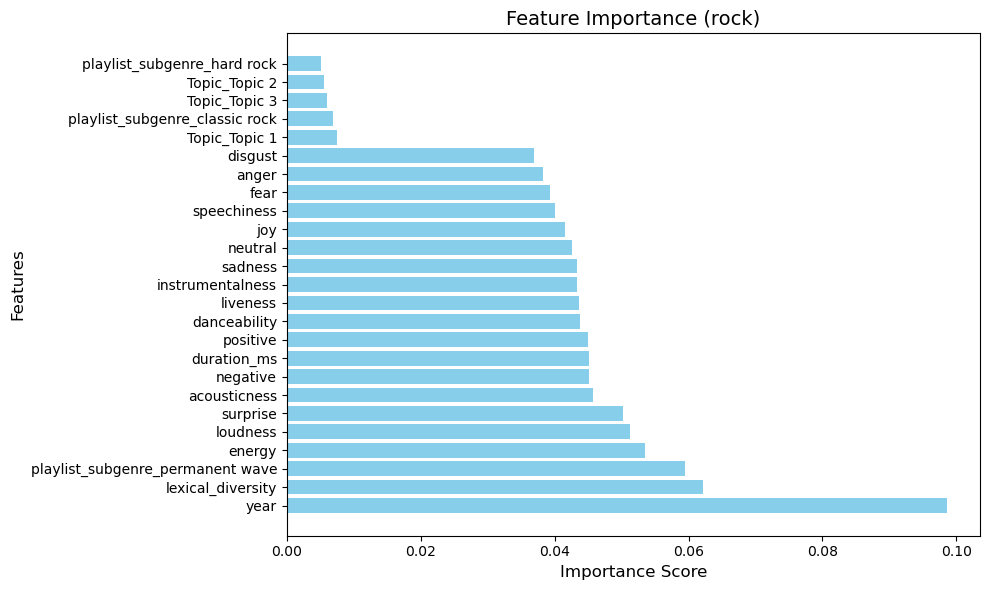

In [129]:
# Parameters for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [20, 30],
}

# Process data for the selected genre and retrieve feature names
X_train, X_test, y_train, y_test, feature_names = process_genre_data(df, 'rock')

# Analyze the genre "rock"
rock_results = analyze_genre(df, 'rock', param_grid, X_train, X_test, y_train, y_test, feature_names, threshold=0.5)

Logistic Regression:
Processing Genre: rock
Accuracy for rock: 0.6715
Classification Report for rock:
               precision    recall  f1-score   support

           0       0.86      0.65      0.74       349
           1       0.45      0.72      0.56       138

    accuracy                           0.67       487
   macro avg       0.65      0.69      0.65       487
weighted avg       0.74      0.67      0.69       487



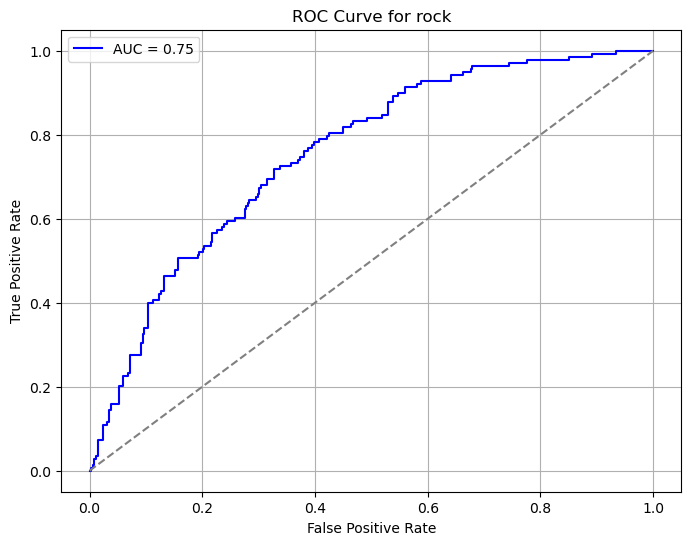

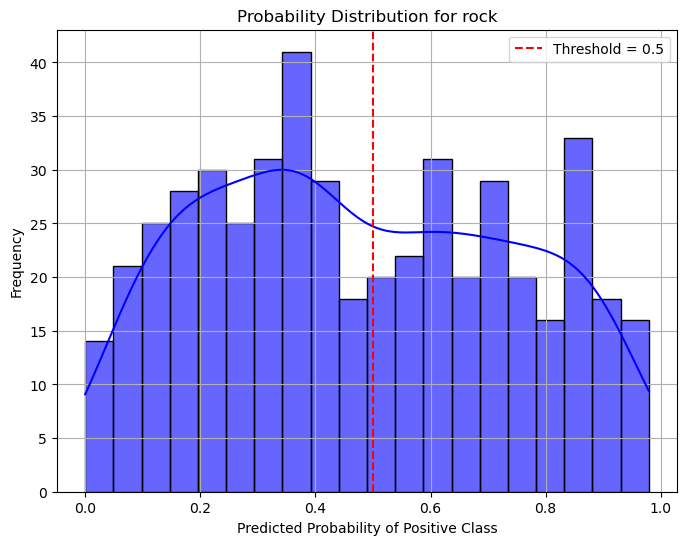

Top Features for rock:
                                  Coefficient  Odds Ratio
playlist_subgenre_permanent wave     0.821856    2.274717
loudness                             0.632592    1.882483
danceability                         0.405979    1.500772
playlist_subgenre_hard rock          0.346494    1.414100
duration_ms                          0.272251    1.312917
negative                             0.124349    1.132411
speechiness                          0.111410    1.117853
sadness                              0.093687    1.098215
positive                             0.085385    1.089137
anger                                0.074699    1.077560
Topic_Topic 1                        0.035713    1.036359
fear                                 0.016423    1.016558
surprise                            -0.021896    0.978342
liveness                            -0.027511    0.972864
instrumentalness                    -0.035857    0.964778
acousticness                        -0.046634    

In [125]:
#Rock
analyze_logistic_regression(df, 'rock', X_train, X_test, y_train, y_test, feature_names, threshold = 0.5 )

#### 5.3. Pop
- 1. Model: 
    - Random Forest outperforms Logistic Regression for the pop genre, with an accuracy of 72.94% compared to 69.04%.
    - Both models display moderate recall for predicting popular songs 69% but a higher precision that previous models, 64%
    - The ROC curve indicates a better discriminatory ability (AUC = 0.77).

- 2. Feature importance: 
    - Lexical Diversity: Dominates as the most important predictor, with simpler lyrics strongly correlating with popularity.
    - Instrumentalness and Speechiness: Pop songs with less instrumental focus and high speechiness in the audio are influential for popular songs
    - Playlist Subgenre Subgenre "Indie Poptimism" negatively impact popularity.
    - lyrics variables have a very moderate effect

Processing data for genre: pop
Random Forest:
Processing Genre: pop
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.3s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.3s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.3s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.3s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.3s
[CV] END .....................max_depth=20, n_estimators=200; total time=   0.7s
[CV] END .....................max_depth=20, n_estimators=200; total time=   0.6s
[CV] END .....................max_depth=20, n_estimators=200; total time=   0.6s
[CV] END .....................max_depth=20, n_estimators=200; total time=   0.6s
[CV] END .....................max_depth=20, n_estimators=200; total time=   0.6s
[CV] END .....................max_depth=30, n_estimators=100; 

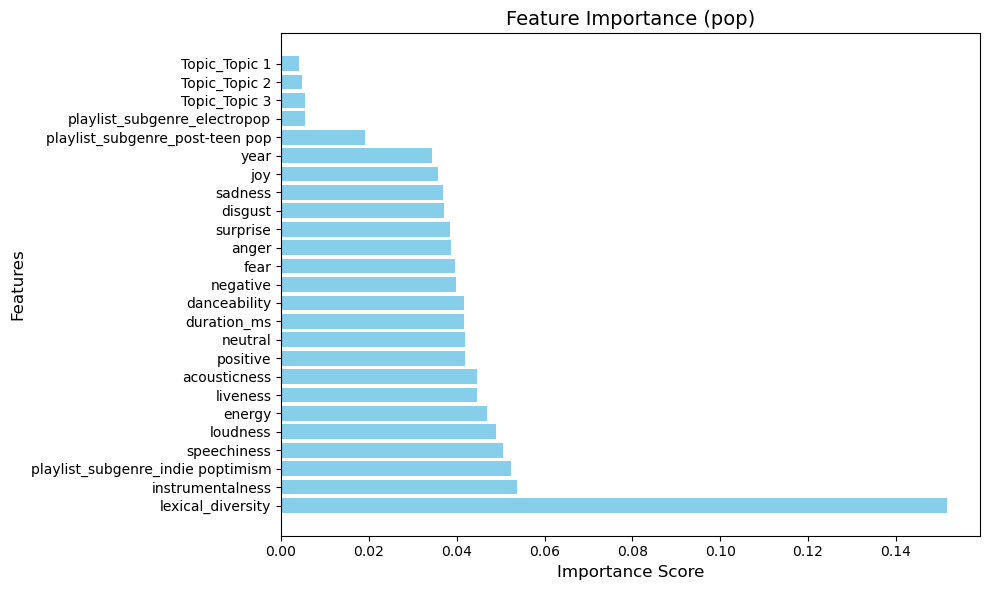

In [131]:
# Parameters for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [20, 30],
}

# Process data for the selected genre and retrieve feature names
X_train, X_test, y_train, y_test, feature_names = process_genre_data(df, 'pop')

# Analyze the genre "pop"
rock_results = analyze_genre(df, 'pop', param_grid, X_train, X_test, y_train, y_test, feature_names, threshold=0.5)

Logistic Regression:
Processing Genre: pop
Accuracy for pop: 0.6904
Classification Report for pop:
               precision    recall  f1-score   support

           0       0.78      0.69      0.73       549
           1       0.59      0.69      0.63       349

    accuracy                           0.69       898
   macro avg       0.68      0.69      0.68       898
weighted avg       0.70      0.69      0.69       898



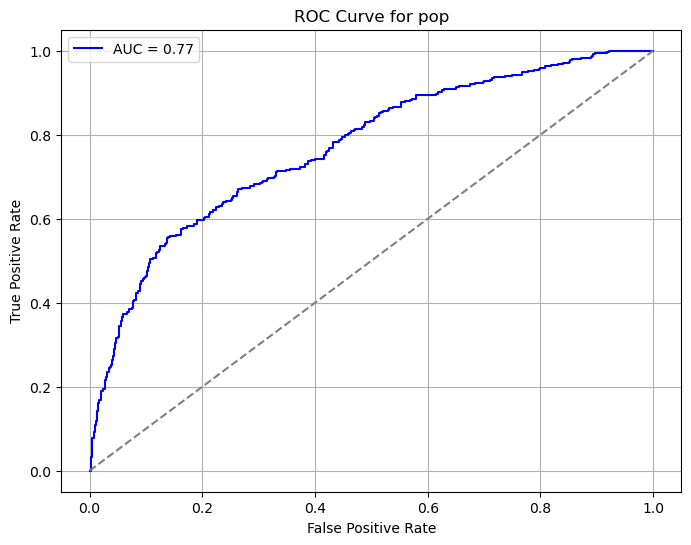

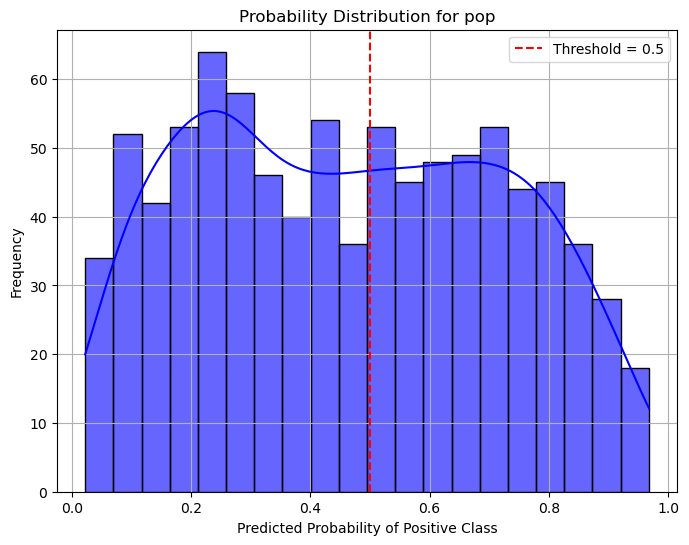

Top Features for pop:
                                   Coefficient  Odds Ratio
loudness                              0.517279    1.677457
speechiness                           0.245110    1.277762
playlist_subgenre_post-teen pop       0.189969    1.209212
negative                              0.097964    1.102923
acousticness                          0.093159    1.097636
danceability                          0.085216    1.088952
year                                  0.032663    1.033202
playlist_subgenre_electropop          0.029419    1.029856
disgust                               0.011962    1.012034
duration_ms                           0.009310    1.009353
fear                                 -0.000674    0.999326
Topic_Topic 2                        -0.004452    0.995558
positive                             -0.014161    0.985938
Topic_Topic 3                        -0.030820    0.969650
liveness                             -0.056861    0.944726
neutral                           

In [132]:
#pop
analyze_logistic_regression(df, 'pop', X_train, X_test, y_train, y_test, feature_names, threshold = 0.5 )

#### 5.4. r&b
- 1. Model: 
    - Logistic regression perform a little better
    - The models have a higher recall for popular songs (75%) but at the cost of false positives (41%)

- 2. Feature importance: 
    - Year: Positive coefficient indicates newer songs are more likely to be popular.
    - Loudness and Danceability: Both positively correlated with popularity. Loud and danceable R&B tracks are more engaging.
    - Lexical Diversity: Low lexical diversity (simpler lyrics) significantly predicts popularity (negative coefficient in Logistic Regression: -0.41).
    - Energy: Songs with lower energy are more likely to be popular
    - "Neo Soul" subgenre is negatively correlated with popularity, as indicated by its coefficients and low feature importance.
    - Topics derived from LDA analysis contribute minimally to predictions, as shown in both models.

Processing data for genre: r&b
Random Forest:
Processing Genre: r&b
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=20, n_estimators=200; total time=   0.3s
[CV] END .....................max_depth=20, n_estimators=200; total time=   0.3s
[CV] END .....................max_depth=20, n_estimators=200; total time=   0.3s
[CV] END .....................max_depth=20, n_estimators=200; total time=   0.3s
[CV] END .....................max_depth=20, n_estimators=200; total time=   0.3s
[CV] END .....................max_depth=30, n_estimators=100; 

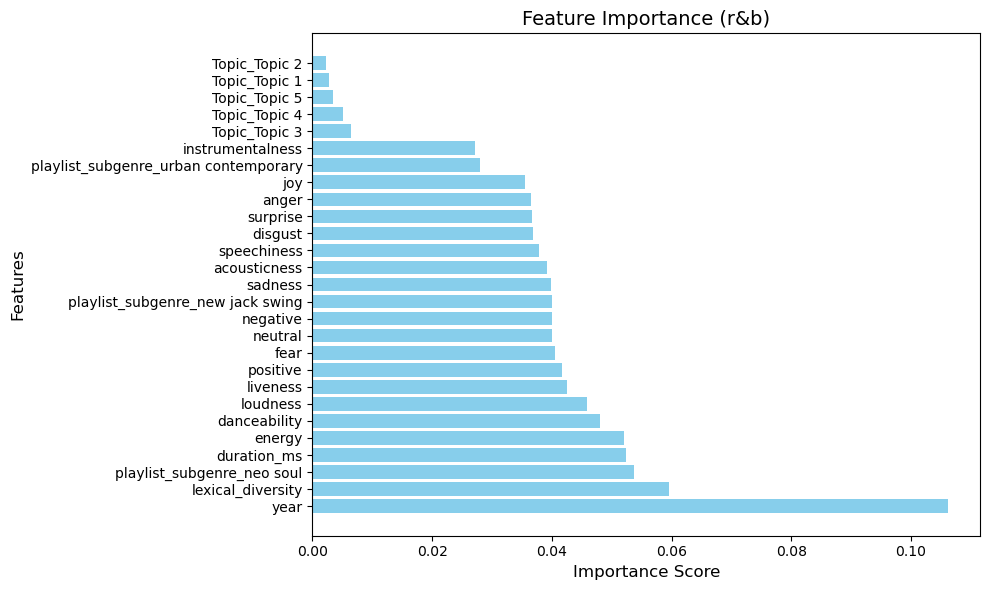

In [133]:
# Parameters for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [20, 30],
}

# Process data for the selected genre and retrieve feature names
X_train, X_test, y_train, y_test, feature_names = process_genre_data(df, 'r&b')

rock_results = analyze_genre(df, 'r&b', param_grid, X_train, X_test, y_train, y_test, feature_names, threshold=0.5)

Logistic Regression:
Processing Genre: r&b
Accuracy for r&b: 0.7254
Classification Report for r&b:
               precision    recall  f1-score   support

           0       0.91      0.72      0.80       551
           1       0.43      0.75      0.55       159

    accuracy                           0.73       710
   macro avg       0.67      0.73      0.68       710
weighted avg       0.80      0.73      0.75       710



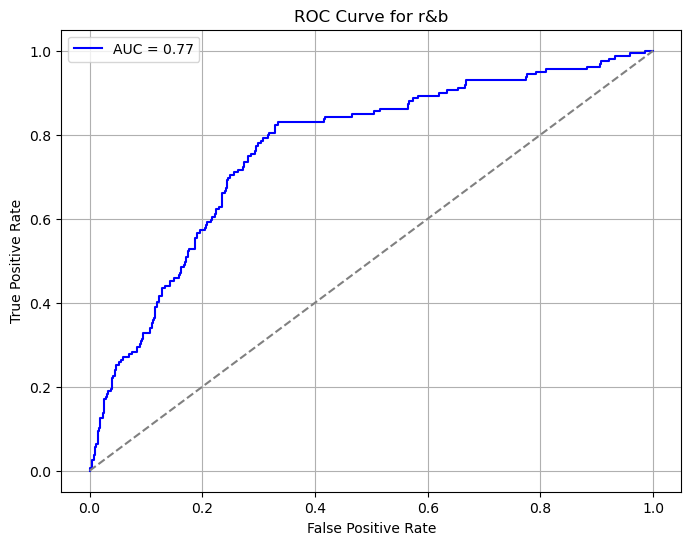

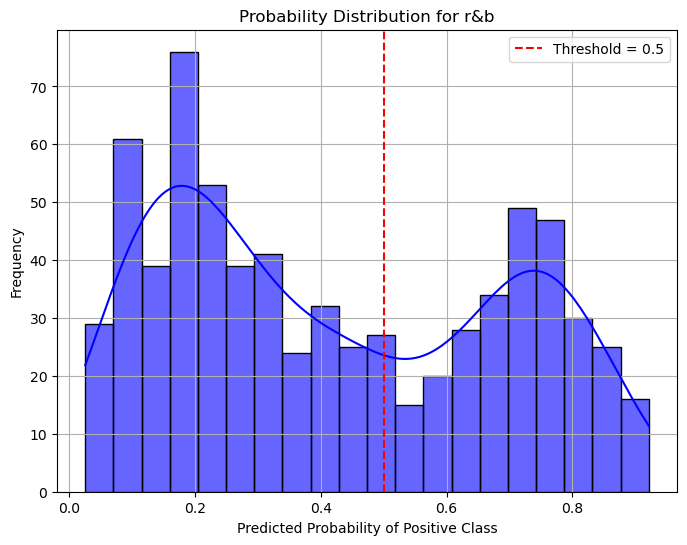

Top Features for r&b:
                                      Coefficient  Odds Ratio
year                                     0.406203    1.501108
loudness                                 0.256819    1.292811
danceability                             0.205635    1.228304
negative                                 0.024722    1.025030
positive                                 0.016189    1.016321
speechiness                             -0.013721    0.986373
instrumentalness                        -0.028381    0.972018
disgust                                 -0.029976    0.970469
duration_ms                             -0.036181    0.964466
neutral                                 -0.047092    0.954000
acousticness                            -0.055848    0.945683
Topic_Topic 3                           -0.071120    0.931350
Topic_Topic 1                           -0.078788    0.924236
liveness                                -0.081730    0.921521
fear                                    -0.09131

In [134]:
#r&b
analyze_logistic_regression(df, 'r&b', X_train, X_test, y_train, y_test, feature_names, threshold = 0.5 )

#### 5.5. edm
- 1. Model: 
    - Both models have a high precision for identifying non popular songs, but low power to identify popular songs.
    - Both models show weak discrimination ability, with AUC values close to random guessing, reflecting the difficulty of predicting popularity in EDM.
    - The model struggle is due to the high imbalance in the data of song from edm 

- 2. Feature importance: 
    - Playlist Subgenres: "Pop EDM" and "Electro House" were the strongest predictors of popularity, with positive correlations.
    - Duration: Negatively correlated, shorter tracks are more likely to be popular.
    - Loudness and Danceability are highly associated with popular edm songs


Processing data for genre: edm
Random Forest:
Processing Genre: edm
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.0s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.0s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.0s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.0s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.0s
[CV] END .....................max_depth=20, n_estimators=200; total time=   0.1s
[CV] END .....................max_depth=20, n_estimators=200; total time=   0.1s
[CV] END .....................max_depth=20, n_estimators=200; total time=   0.1s
[CV] END .....................max_depth=20, n_estimators=200; total time=   0.1s
[CV] END .....................max_depth=20, n_estimators=200; total time=   0.1s
[CV] END .....................max_depth=30, n_estimators=100; 

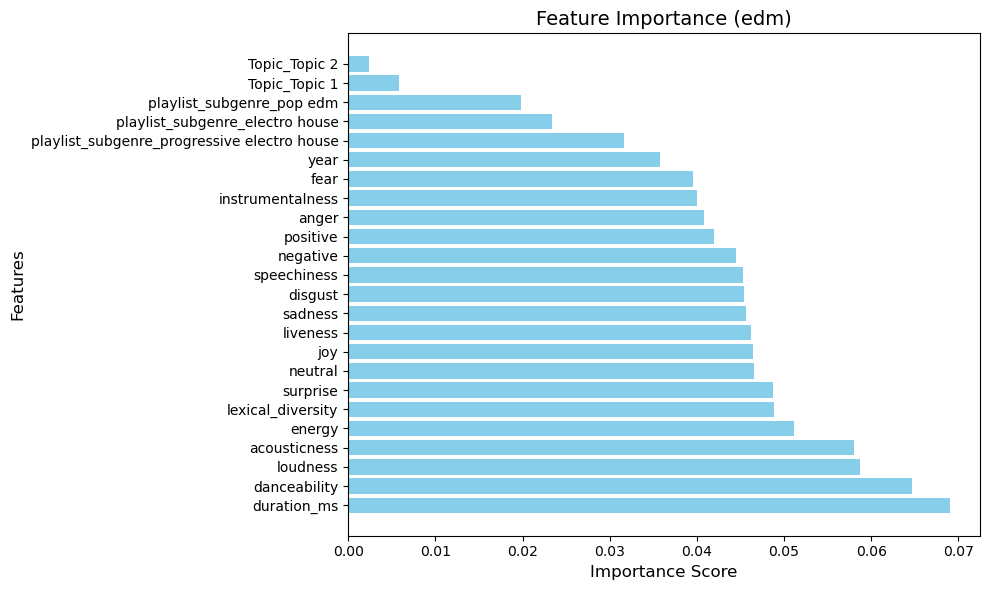

In [136]:
# Parameters for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [20, 30],
}

# Process data for the selected genre and retrieve feature names
X_train, X_test, y_train, y_test, feature_names = process_genre_data(df, 'edm')

rock_results = analyze_genre(df, 'edm', param_grid, X_train, X_test, y_train, y_test, feature_names, threshold=0.5)

Logistic Regression:
Processing Genre: edm
Accuracy for edm: 0.5838
Classification Report for edm:
               precision    recall  f1-score   support

           0       0.90      0.60      0.72       340
           1       0.13      0.48      0.20        42

    accuracy                           0.58       382
   macro avg       0.51      0.54      0.46       382
weighted avg       0.82      0.58      0.66       382



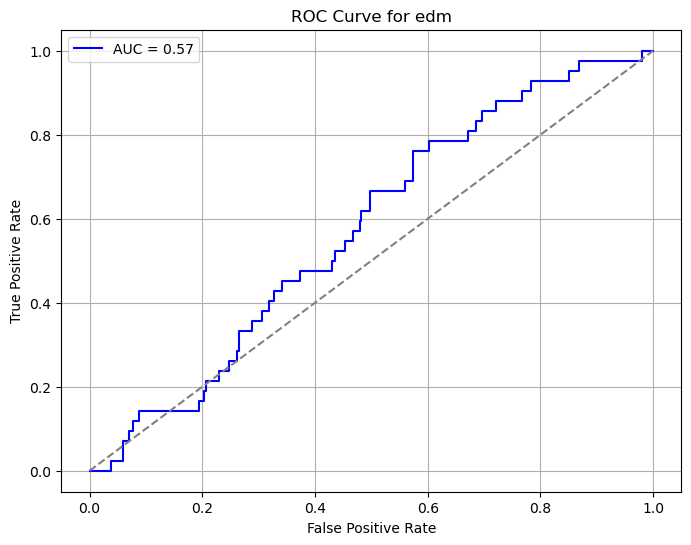

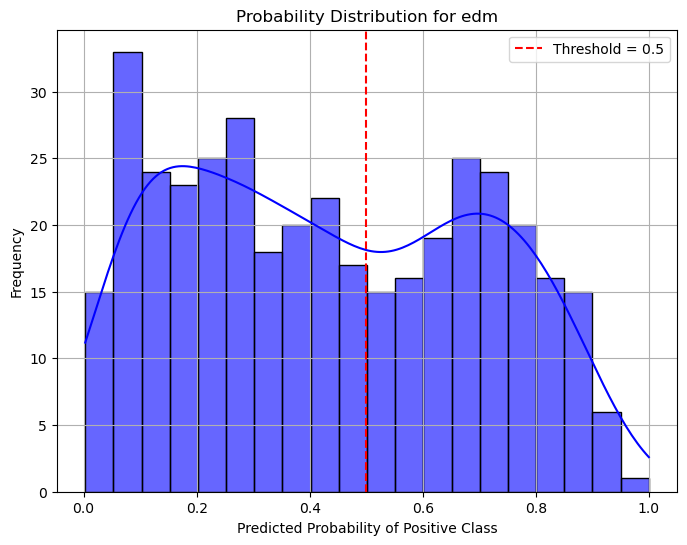

Top Features for edm:
                                             Coefficient  Odds Ratio
playlist_subgenre_pop edm                       0.789508    2.202313
playlist_subgenre_electro house                 0.739031    2.093906
loudness                                        0.340711    1.405946
danceability                                    0.316182    1.371880
Topic_Topic 2                                   0.239958    1.271195
disgust                                         0.238355    1.269160
Topic_Topic 1                                   0.195307    1.215684
neutral                                         0.080443    1.083767
playlist_subgenre_progressive electro house     0.066201    1.068441
fear                                            0.029170    1.029600
negative                                       -0.006918    0.993106
speechiness                                    -0.015692    0.984431
sadness                                        -0.027077    0.973287
anger       

In [138]:
#edm
analyze_logistic_regression(df, 'edm', X_train, X_test, y_train, y_test, feature_names, threshold = 0.5 )

#### 5.6. latin
- 1. Model
    - Both models achieve the same accuracy of 64.51%, suggesting moderate prediction power.
    - Popular category recall is moderate (67%-68%), indicating that the models can identify popular songs but with less reliability.
    - The ROC curve indicates a moderate discriminatory power, with an AUC of 0.70 

- 2. Feature importance: 
    - Loudness: The most significant predictor in both models, with positive correlation showing louder songs are more likely to be popular.
    - Year: Newer songs are positively associated with popularity, though less impactful than loudness.
    - Lexical Diversity: Simpler lyrics are favored, as lower lexical diversity correlates with higher popularity.
    - Reggaeton subgenre positively influences popularity, reflecting audience preferences for this style in Latin music.


Processing data for genre: latin
Random Forest:
Processing Genre: latin
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=20, n_estimators=200; total time=   0.3s
[CV] END .....................max_depth=20, n_estimators=200; total time=   0.2s
[CV] END .....................max_depth=20, n_estimators=200; total time=   0.3s
[CV] END .....................max_depth=20, n_estimators=200; total time=   0.3s
[CV] END .....................max_depth=20, n_estimators=200; total time=   0.3s
[CV] END .....................max_depth=30, n_estimators=1

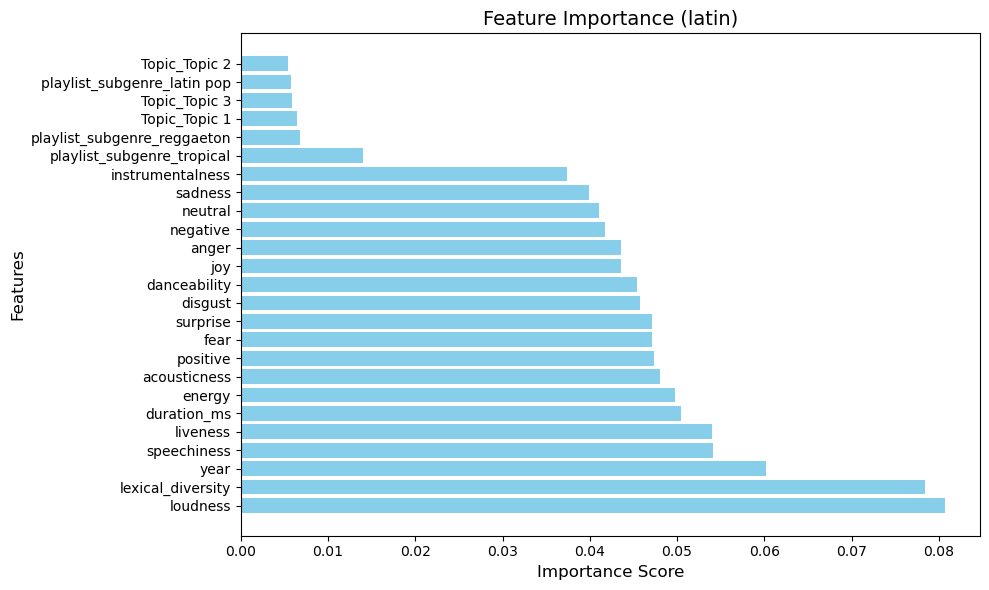

In [139]:
# Parameters for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [20, 30],
}

# Process data for the selected genre and retrieve feature names
X_train, X_test, y_train, y_test, feature_names = process_genre_data(df, 'latin')

rock_results = analyze_genre(df, 'latin', param_grid, X_train, X_test, y_train, y_test, feature_names, threshold=0.5)

Logistic Regression:
Processing Genre: latin
Accuracy for latin: 0.6451
Classification Report for latin:
               precision    recall  f1-score   support

           0       0.79      0.63      0.70       294
           1       0.49      0.68      0.57       154

    accuracy                           0.65       448
   macro avg       0.64      0.65      0.63       448
weighted avg       0.69      0.65      0.65       448



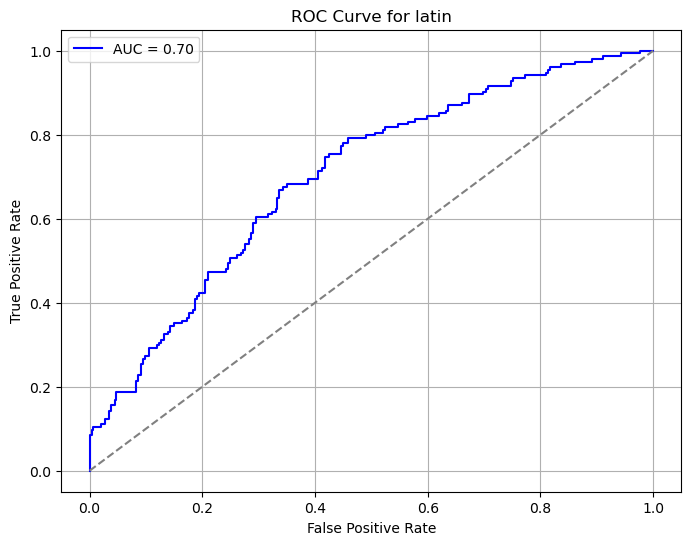

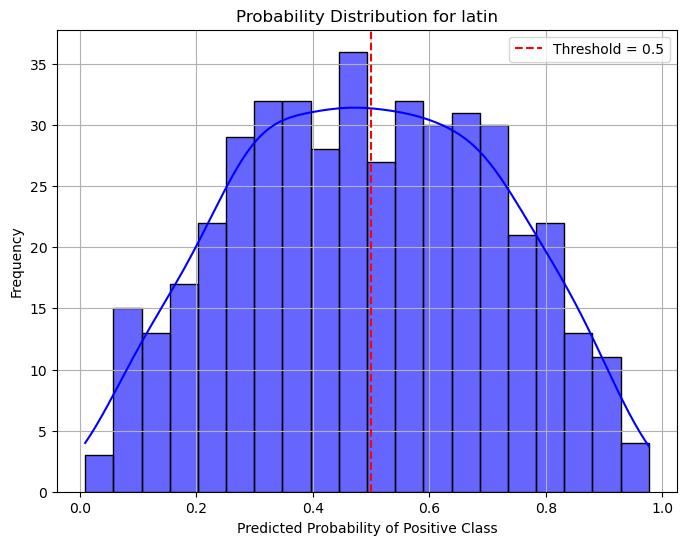

Top Features for latin:
                             Coefficient  Odds Ratio
loudness                        0.850561    2.340960
year                            0.216659    1.241921
playlist_subgenre_reggaeton     0.207111    1.230119
acousticness                    0.196564    1.217213
Topic_Topic 1                   0.096821    1.101663
negative                        0.051433    1.052779
playlist_subgenre_latin pop     0.022936    1.023201
neutral                        -0.015690    0.984433
danceability                   -0.021595    0.978637
positive                       -0.027264    0.973104
surprise                       -0.034348    0.966235
duration_ms                    -0.041056    0.959775
Topic_Topic 3                  -0.045825    0.955209
speechiness                    -0.070756    0.931690
anger                          -0.131746    0.876564
Topic_Topic 2                  -0.133943    0.874640
instrumentalness               -0.157130    0.854593
disgust               

In [140]:
#latin
analyze_logistic_regression(df, 'latin', X_train, X_test, y_train, y_test, feature_names, threshold = 0.5 )

### 6. Conclusions

#### General Model insights

- Predictors in Common:
    - Lexical Diversity: A consistent predictor across all genres, with simpler lyrics (lower lexical diversity) generally associated with more popular songs.
    - Loudness and Danceability: Audio features like loudness and danceability are significant predictors, emphasizing the impact on audio qualities on song popularity.
    - Year: Newer songs generally correlate positively with popularity across most genres, except in rock
    - Sentiments and Emotions: show moderate but less consistent importance compared to audio features.
    
- Feature divergence:
    - Certain subgenres are important depending on the genre
    - Topics derived from LDA analysis have minimal importance in most genres, suggesting that thematic diversity is less critical to popularity.

- Model perfomance:
    - The Random Forest and Logistic Regression models performed differently across genres, with Random Forest generally excelling due to its ability to capture complex relationships
    - Precision and recall for popular songs trade-offs highlight challenges with imbalanced datasets

#### Genre specific insights

- Rap
    - Simpler lyrics and louder, newer tracks are key predictors of popularity.
    - Subgenre "Hip Hop" is influential, reflecting trend within rap's audience

- Rock
    - Old songs tend to have a higher popularity than new songs
    - Subgenre "Permanent Wave" is a significant feature, possibly due to its mainstream crossover.
- Pop
    - Pop songs with less instrumental focus and high speechiness in the audio are influential for popular songs
    - Subgenre "Indie Poptimism"  impact negatively the popularity.

- r&b
    - "Neo Soul" subgenre is negatively correlated with popularity
    - Energy: Songs with lower energy are more likely to be popular

- edm
    - shorter tracks are more likely to be popular.
    - "Pop EDM" and "Electro House" strongly correlate with popularity, reflecting the genre's structure.

- latin
    - Year, loudness, and "Reggaeton" subgenre are crucial for predicting popularity.


### Final insight for the business problem

- Focus on creating songs with high energy, loudness, and danceability to align with listener preferences across multiple genres.
- Simpler lyrics resonate better with audiences, emphasizing clarity and repeatability in lyrics.
- For genre-specific recomendations:
    - Rap: Leverage subgenres like "Hip-Hop" and focus on high-energy, loud production styles
    - Rock: Old songs are still more popular than newer songs, production need to imitate old rock songs to appeal the audience
    - Pop: avoid the subgenre "Indice poptimism"
    - R&B: Maintain a balance of acoustic and modern production to appeal to traditional and contemporary audiences.
    - EDM: Prioritize danceability and loudness, ensuring tracks are optimized for festivals and clubs and short tracks
    - Latin: Highlight reggaeton elements and acoustic instrumentation to connect with traditional and global audiences.


### Limitations and Improvements

- Feature Selection: Certain features like LDA-derived topics or emotional nuances may not capture the true diversity of song characteristics.
- Temporal Trends: Year-related features dominate predictions but might fail to generalize to older or timeless tracks.
- Dataset Imbalance: The results are influenced by the dataset's composition, particularly its balance across genres and popularity classes.

- Recommendations:
    - Incorporate additional data like streaming metrics ( play counts or playlist placements) to refine predictions.
    - Experiment with neural networks or hybrid models to capture deeper relationships between features.
    - Address class imbalance by using oversampling techniques or adjusting the decision threshold dynamically.
    - Explore more advanced NLP techniques to extract richer semantic meaning from lyrics.